PRE-PROCESSING AUDIO DATA

In [2]:
#Importing Libraries

import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow import keras
import json
import os
import math
import random
import IPython



Locate the DATASET

In [3]:
Path = 'D:\Minor\dataset' 

In [4]:
# load audio file with Librosa

FIG_SIZE = (15,10)
file = Path + '/genres_original/blues/blues.00000.wav'
signal, sample_rate = librosa.load(file, sr=22050)

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\149943227.py:5: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(signal, sample_rate, alpha=0.4)


Text(0.5, 1.0, 'Waveform')

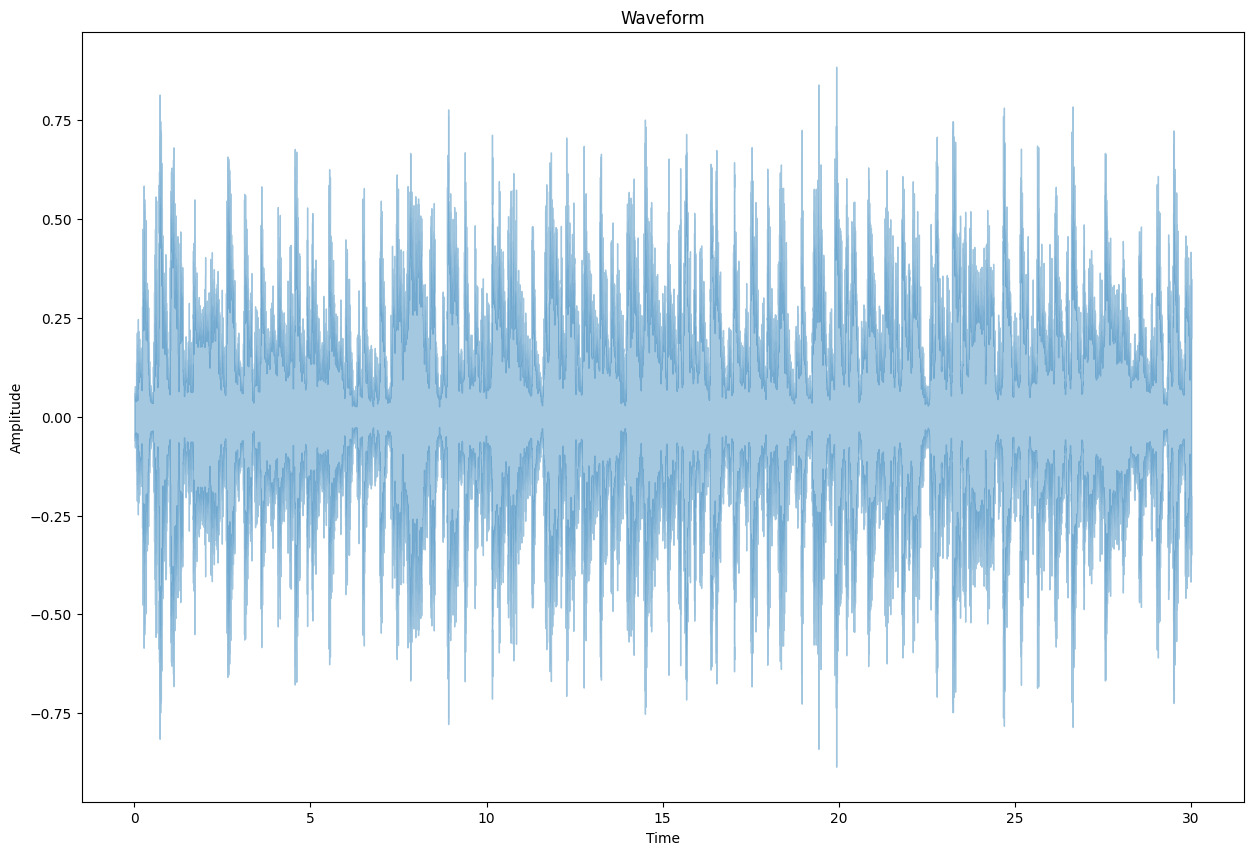

In [5]:
# WAVEFORM
# display waveform

plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(signal, sample_rate, alpha=0.4)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Waveform")

In [6]:
# FFT -> power spectrum
# perform Fourier transform

fft = np.fft.fft(signal)

In [7]:
# calculate abs values on complex numbers to get magnitude

spectrum = np.abs(fft)

In [8]:
# create frequency variable

f = np.linspace(0, sample_rate, len(spectrum))

Text(0.5, 1.0, 'Power Spectrum')

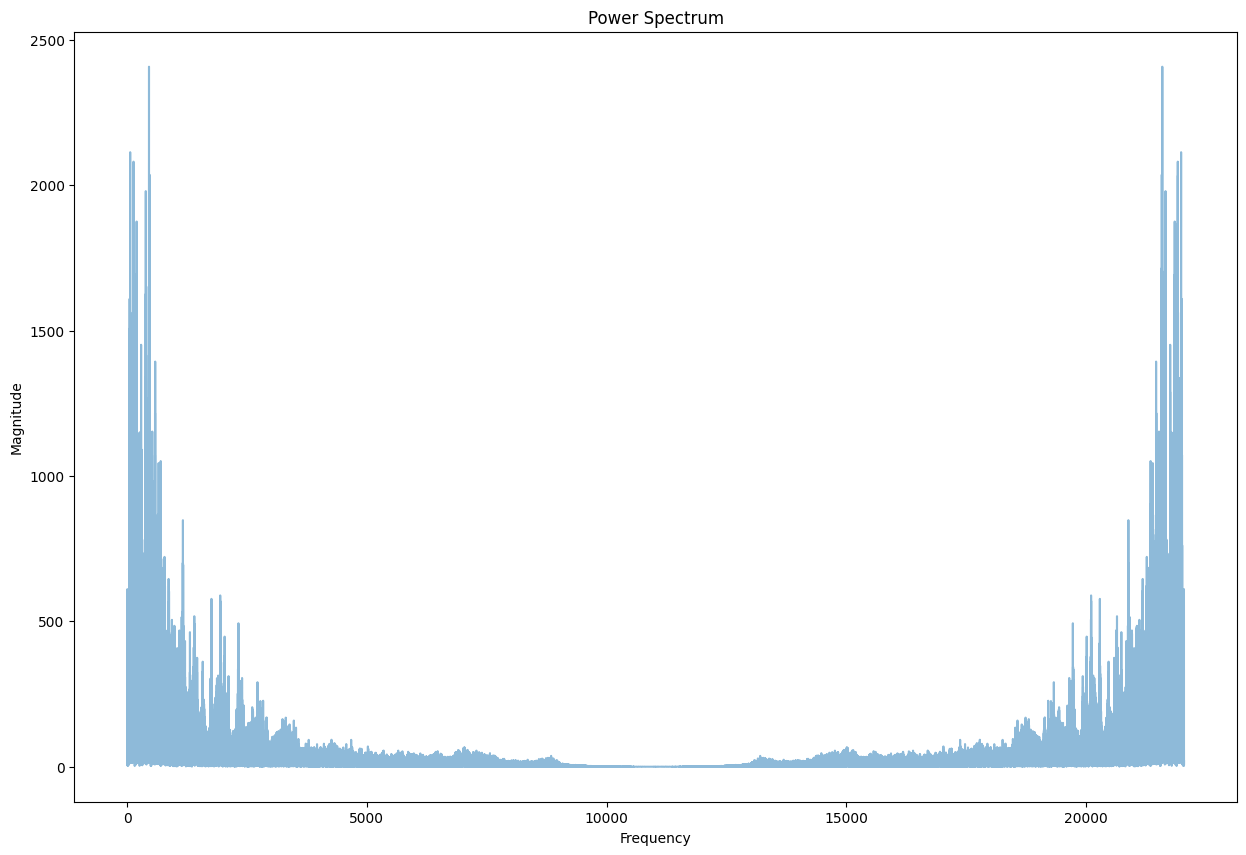

In [9]:
# Plot Spectrum

plt.figure(figsize=FIG_SIZE)
plt.plot(f, spectrum, alpha=0.5)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power Spectrum")

In [10]:
# take half of the spectrum and frequency

left_spectrum = spectrum[:int(len(spectrum)/2)]
left_f = f[:int(len(spectrum)/2)]

Text(0.5, 1.0, 'Power spectrum')

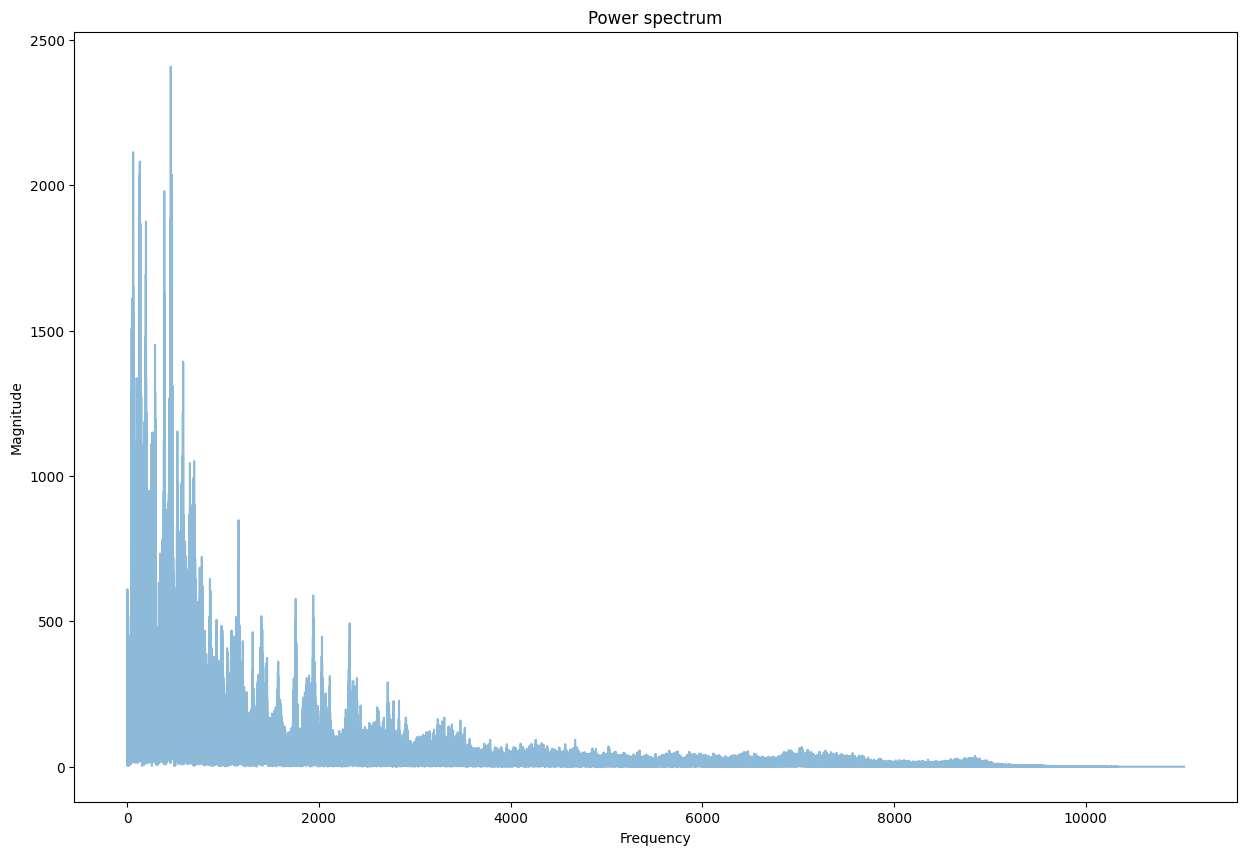

In [11]:
# plot spectrum

plt.figure(figsize=FIG_SIZE)
plt.plot(left_f, left_spectrum, alpha=0.5)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")

In [12]:
# STFT -> spectrogram

hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples


In [13]:
# calculate duration hop length and window in seconds

hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate
print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


In [14]:
# perform stft
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

In [15]:
# calculate abs values on complex numbers to get magnitude
spectrogram = np.abs(stft)

Text(0.5, 1.0, 'Spectrogram')

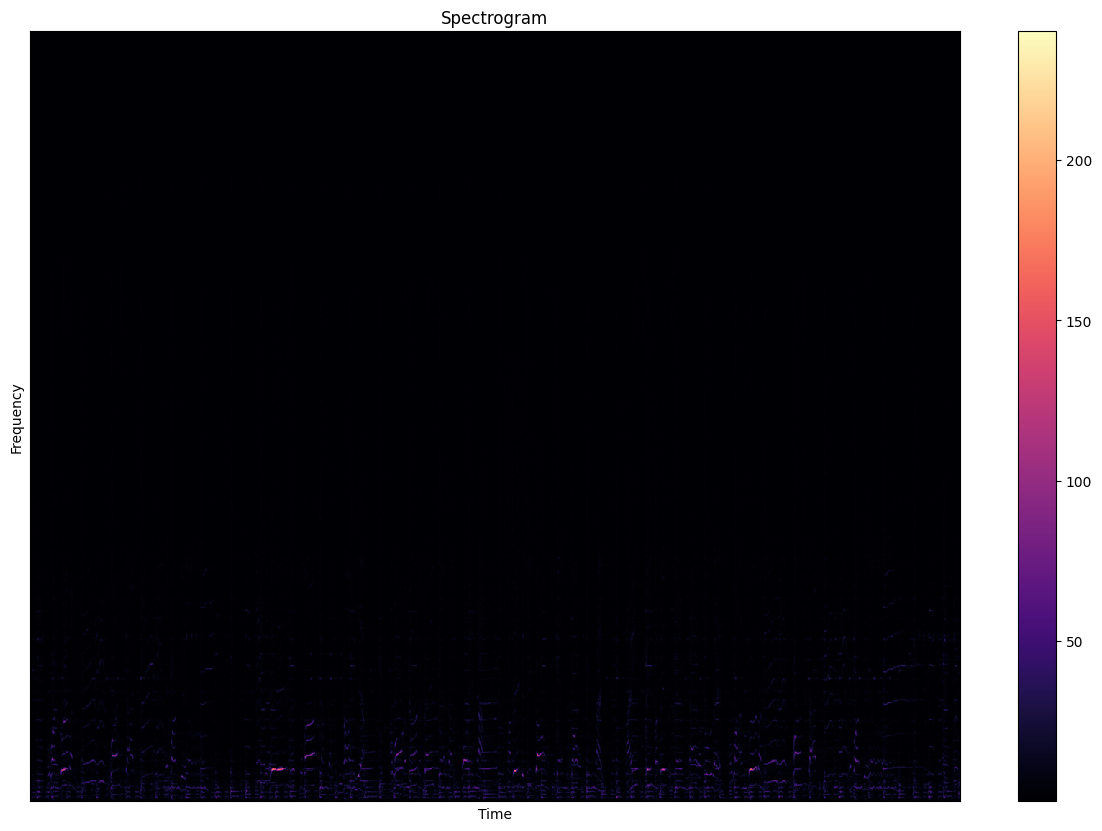

In [16]:
# display spectrogram

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

In [17]:
# apply logarithm to cast amplitude to Decibels

log_spectrogram = librosa.amplitude_to_db(spectrogram)


Text(0.5, 1.0, 'Spectrogram (dB)')

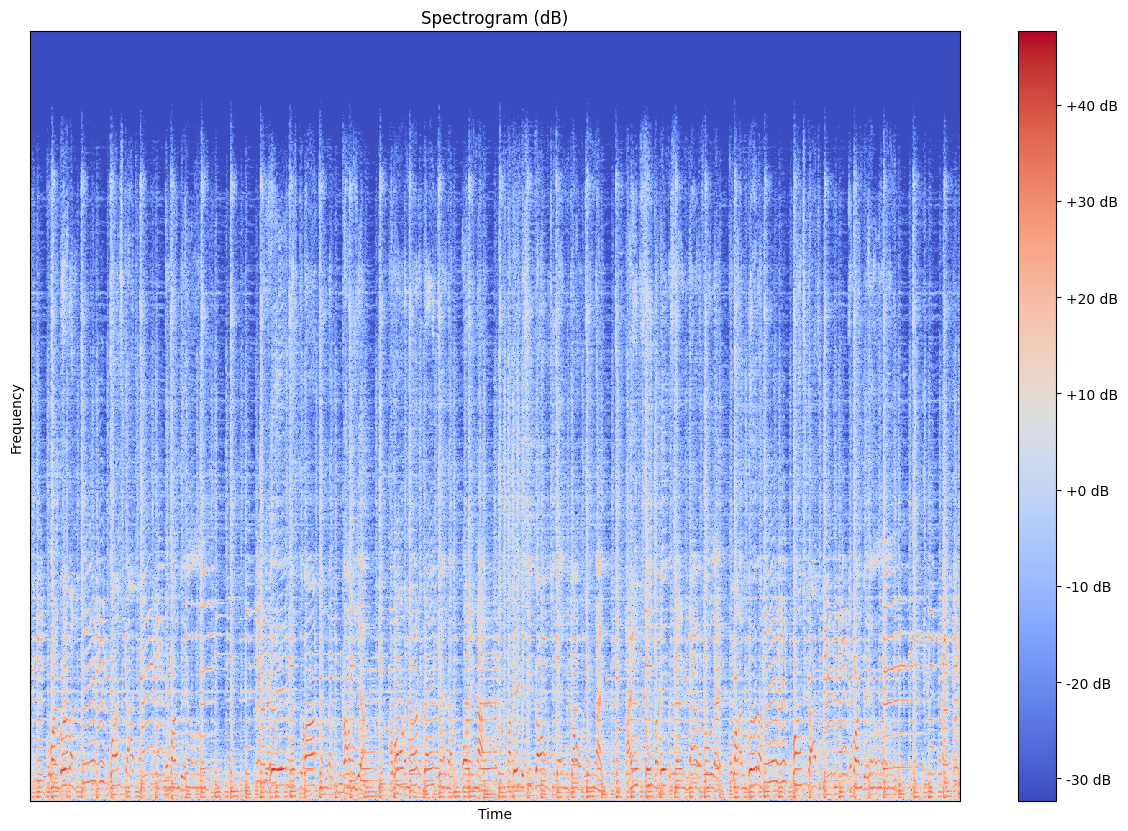

In [18]:
# Plot the Spectrogram in Decibels

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

In [19]:
# MFCCs
# extract 13 MFCCs
MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1113811453.py:3: FutureWarning: Pass y=[ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)


Text(0.5, 1.0, 'MFCCs')

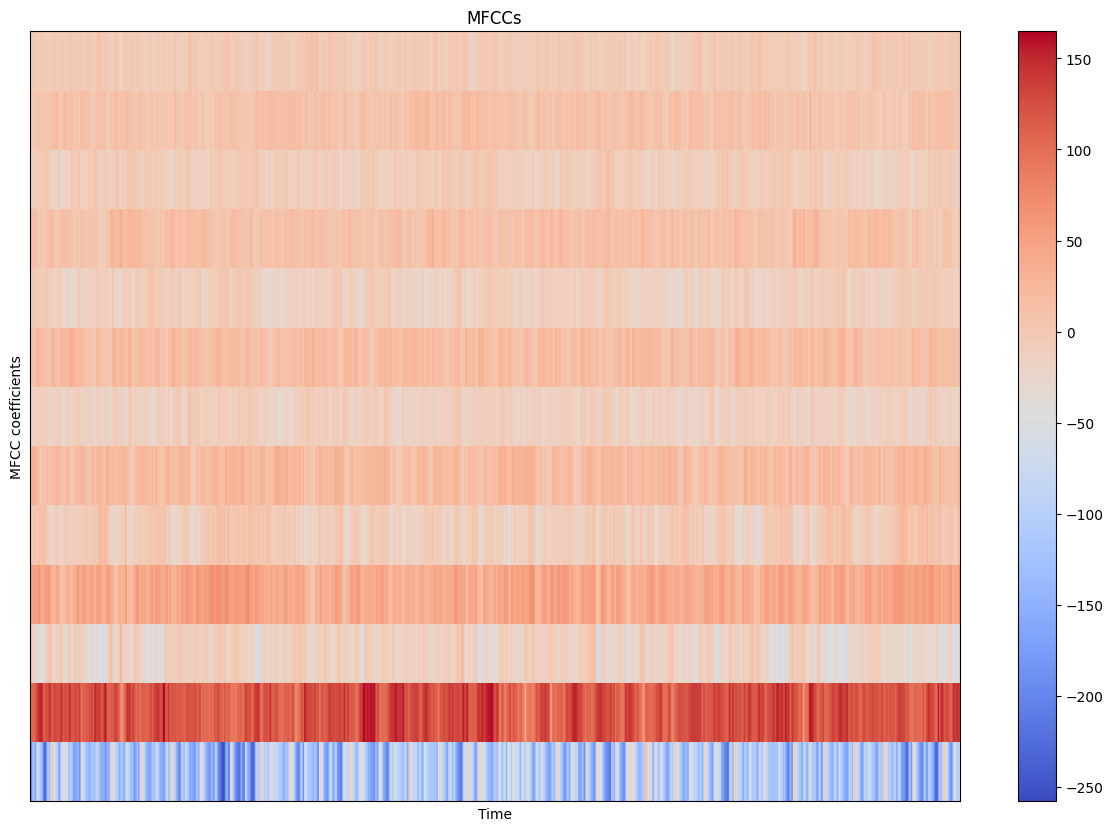

In [20]:
# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

DATA EXTRACTION

In [21]:
DATASET_PATH = Path + '/genres_original'
JSON_PATH = 'data_10.json'
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


In [22]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		# load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        

In [23]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


Processing: genres_original\blues
D:\Minor\dataset/genres_original\blues\blues.00000.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00000.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00000.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00000.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00000.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00000.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00000.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00000.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00000.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00000.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00001.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00001.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00001.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00001.wav, segment:4
D:\Minor\dataset/genres_original\blues\b

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00732422  0.01660156  0.00762939 ... -0.04373169 -0.05706787
 -0.04086304], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02481079 -0.02005005 -0.0357666  ...  0.00918579  0.03964233
  0.09030151], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.06256104  0.02435303 -0.00405884 ...  0.2854004   0.29364014
  0.25228882], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\blues\blues.00002.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00002.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00002.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00002.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00002.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00002.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00002.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00002.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00002.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00002.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00003.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00003.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00003.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00003.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00003.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.04547119 0.02957153 0.00296021 ... 0.17419434 0.17919922 0.15707397], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.15585327  0.2084961   0.22970581 ... -0.02020264 -0.00274658
  0.00723267], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02429199 -0.02975464 -0.00961304 ...  0.         -0.01425171
 -0.02456665], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\blues\blues.00007.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00007.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00007.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00007.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00008.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00008.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00008.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00008.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00008.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00008.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00008.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00008.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00008.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00008.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00009.wav, segment:1
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04315186 -0.05490112 -0.05880737 ...  0.5109863   0.49053955
  0.28253174], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.24356079 -0.7022095  -0.4602356  ... -0.13394165 -0.14245605
 -0.15756226], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.13192749 -0.08340454 -0.03442383 ... -0.23309326 -0.18496704
 -0.1531372 ], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\blues\blues.00009.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00009.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00009.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00010.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00010.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00010.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00010.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00010.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00010.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00010.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00010.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00010.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00010.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00011.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00011.wav, segment:2
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.034729   -0.02868652 -0.02206421 ...  0.5458374   0.43777466
  0.2937317 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.24438477  0.25125122  0.18432617 ... -0.00680542 -0.0177002
 -0.02374268], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.12014771 0.14956665 0.10458374 ... 0.02032471 0.019104   0.02075195], sr=22050 as keyword args. From version 0.10 pas

D:\Minor\dataset/genres_original\blues\blues.00012.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00012.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00012.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00012.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00012.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00012.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00012.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00012.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00012.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00012.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00013.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00013.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00013.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00013.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00013.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03015137 -0.0453186  -0.04034424 ... -0.06985474 -0.11755371
 -0.15158081], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.15426636 -0.11071777 -0.03424072 ... -0.0012207  -0.00314331
 -0.00506592], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00601196 -0.00540161 -0.00360107 ... -0.28390503 -0.14428711
  0.08300781], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\blues\blues.00017.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00017.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00017.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00017.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00017.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00017.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00017.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00017.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00017.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00017.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00018.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00018.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00018.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00018.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00018.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.02389526 0.01803589 0.01559448 ... 0.06307983 0.06771851 0.06854248], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.06506348  0.05737305  0.04641724 ... -0.03570557 -0.04388428
 -0.04727173], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04107666 -0.02587891 -0.01422119 ...  0.12820435  0.10943604
  0.08493042], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\blues\blues.00020.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00020.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00020.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00020.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00020.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00020.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00020.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00020.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00020.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00020.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00021.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00021.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00021.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00021.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00021.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03375244  0.0324707   0.03134155 ... -0.05633545 -0.05828857
 -0.05706787], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05682373 -0.05554199 -0.05410767 ... -0.05526733 -0.05532837
 -0.05535889], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.17184448  0.20730591  0.08227539 ... -0.05078125 -0.07855225
 -0.09347534], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\blues\blues.00025.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00025.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00025.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00025.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00025.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00025.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00025.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00025.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00025.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00025.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00026.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00026.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00026.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00026.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00026.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.23886108 -0.41534424 -0.3161621  ...  0.3184204   0.24853516
  0.2013855 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.18481445  0.18530273  0.18200684 ... -0.02203369 -0.0241394
 -0.02624512], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02703857 -0.02972412 -0.03411865 ... -0.07894897 -0.06732178
 -0.05328369], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\blues\blues.00028.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00028.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00028.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00028.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00028.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00028.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00028.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00028.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00028.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00028.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00029.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00029.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00029.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00029.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00029.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00128174 -0.02716064 -0.02966309 ...  0.04873657  0.04074097
  0.02758789], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01834106  0.01190186 -0.00024414 ... -0.22518921 -0.21972656
 -0.21270752], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.21789551 -0.22442627 -0.23379517 ...  0.12115479  0.14215088
  0.13195801], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\blues\blues.00033.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00033.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00033.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00033.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00033.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00033.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00033.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00033.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00033.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00034.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00034.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00034.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00034.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00034.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00034.wav, segment:6
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.18869019 0.19281006 0.23617554 ... 0.04275513 0.04284668 0.04006958], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.04138184 0.04025269 0.03112793 ... 0.13623047 0.1465149  0.14233398], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.12139893 0.12982178 0.1381836  ... 0.04605103 0.0333252  0.02975464], sr=22050 as keyword args. From version 0.10 passing these as

D:\Minor\dataset/genres_original\blues\blues.00036.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00036.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00036.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00036.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00036.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00036.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00036.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00036.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00036.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00037.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00037.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00037.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00037.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00037.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00037.wav, segment:6
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.10650635 -0.11090088 -0.1126709  ... -0.12484741 -0.14135742
 -0.15213013], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.15640259 -0.15890503 -0.15686035 ...  0.27172852  0.27386475
  0.306427  ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.3086548  0.32089233 0.34951782 ... 0.12145996 0.09976196 0.0776062 ], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\blues\blues.00039.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00039.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00039.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00039.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00039.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00039.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00039.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00039.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00039.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00039.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00040.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00040.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00040.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00040.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00040.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.27105713 -0.26168823 -0.26687622 ... -0.09677124  0.06158447
 -0.0355835 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-3.3660889e-02  9.8144531e-02 -1.2673950e-01 ... -2.5329590e-02
 -9.2468262e-03 -6.1035156e-05], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.03710938 0.07446289 0.07992554 ... 0.07580566 0.08227539 0.05545044], sr=22050 as keyword args. Fr

D:\Minor\dataset/genres_original\blues\blues.00041.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00041.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00042.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00042.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00042.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00042.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00042.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00042.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00042.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00042.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00042.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00042.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00043.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00043.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00043.wav, segment:3
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.24978638  0.23709106  0.22659302 ... -0.02581787  0.00488281
  0.03311157], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00323486 -0.06643677 -0.10803223 ... -0.21255493 -0.15750122
 -0.11898804], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.1008606  -0.11645508 -0.12277222 ...  0.08065796  0.10159302
  0.15261841], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\blues\blues.00047.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00047.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00047.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00047.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00047.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00047.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00048.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00048.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00048.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00048.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00048.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00048.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00048.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00048.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00048.wav, segment:9


C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.16610718 -0.15533447 -0.17355347 ... -0.08789062 -0.09481812
 -0.0770874 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08175659 -0.09631348 -0.09967041 ...  0.0887146   0.08816528
  0.07321167], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.06881714  0.04470825  0.03115845 ... -0.04180908 -0.01577759
 -0.03448486], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\blues\blues.00048.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00049.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00049.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00049.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00049.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00049.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00049.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00049.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00049.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00049.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00049.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00050.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00050.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00050.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00050.wav, segment:4
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04974365 -0.08596802 -0.08615112 ... -0.03436279 -0.04138184
 -0.0463562 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04696655 -0.04711914 -0.04702759 ...  0.03045654  0.04333496
  0.04614258], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.05734253 0.0788269  0.09191895 ... 0.16287231 0.16488647 0.16726685], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\blues\blues.00051.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00051.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00051.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00051.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00051.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00052.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00052.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00052.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00052.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00052.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00052.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00052.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00052.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00052.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00052.wav, segment:10
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.3059082  -0.33718872 -0.33145142 ... -0.39093018 -0.50213623
 -0.4544983 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.32174683 -0.19076538 -0.13034058 ... -0.01867676  0.04486084
  0.03982544], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00387573 -0.02301025 -0.00744629 ...  0.07141113  0.11520386
  0.17822266], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\blues\blues.00054.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00054.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00054.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00054.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00054.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00054.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00054.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00054.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00054.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00055.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00055.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00055.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00055.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00055.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00055.wav, segment:6
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.269104   -0.22070312 -0.17697144 ...  0.02203369 -0.01519775
 -0.0675354 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09579468 -0.08700562 -0.07650757 ... -0.00775146  0.02862549
  0.07037354], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.10412598 0.10165405 0.08950806 ... 0.06384277 0.0770874  0.08300781], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\blues\blues.00057.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00057.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00057.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00057.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00057.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00057.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00057.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00057.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00057.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00057.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00058.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00058.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00058.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00058.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00058.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09057617 -0.05758667  0.11599731 ...  0.03121948 -0.0586853
 -0.12329102], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.07669067 -0.04202271 -0.03598022 ... -0.01470947 -0.02761841
 -0.04483032], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04867554 -0.04116821 -0.06478882 ... -0.00238037 -0.01370239
 -0.05511475], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\blues\blues.00062.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00062.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00062.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00062.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00062.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00062.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00062.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00062.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00062.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00062.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00063.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00063.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00063.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00063.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00063.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00186157  0.01254272  0.02099609 ... -0.10153198 -0.1395874
 -0.1902771 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.2029419  -0.16860962 -0.14141846 ...  0.12771606  0.14556885
  0.08956909], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.06378174  0.08837891  0.04940796 ... -0.17300415 -0.1668396
 -0.1338501 ], sr=22050 as keyword args. From version 0.

D:\Minor\dataset/genres_original\blues\blues.00066.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00066.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00067.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00067.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00067.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00067.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00067.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00067.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00067.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00067.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00067.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00067.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00068.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00068.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00068.wav, segment:3
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.07229614  0.12698364  0.13290405 ... -0.01257324 -0.01647949
 -0.0244751 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04641724 -0.12106323 -0.13388062 ...  0.13955688  0.17327881
  0.20471191], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.1772461   0.06951904 -0.02020264 ... -0.13079834  0.05276489
  0.13616943], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\blues\blues.00069.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00069.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00069.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00069.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00069.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00069.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00070.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00070.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00070.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00070.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00070.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00070.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00070.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00070.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00070.wav, segment:9
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08059692 -0.03353882 -0.01513672 ...  0.05664062  0.04086304
  0.0617981 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.09942627  0.08474731  0.05944824 ...  0.04760742 -0.0161438
 -0.04714966], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.06484985 -0.07122803 -0.06503296 ... -0.00994873 -0.00195312
 -0.01794434], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\blues\blues.00072.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00072.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00072.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00072.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00072.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00072.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00072.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00073.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00073.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00073.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00073.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00073.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00073.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00073.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00073.wav, segment:8
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.04504395  0.05639648  0.0397644  ... -0.06472778 -0.07983398
 -0.08197021], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09124756 -0.10745239 -0.12088013 ...  0.01611328  0.08230591
  0.0725708 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.00900269 0.04556274 0.10424805 ... 0.13952637 0.12280273 0.11380005], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\blues\blues.00074.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00074.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00075.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00075.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00075.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00075.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00075.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00075.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00075.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00075.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00075.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00075.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00076.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00076.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00076.wav, segment:3
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.11993408  0.1104126   0.05038452 ... -0.19335938 -0.0713501
  0.02429199], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.5245056  -0.81640625 -0.5826111  ... -0.0128479  -0.00454712
 -0.03060913], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03295898  0.00222778 -0.00512695 ... -0.3510437  -0.15774536
 -0.01654053], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\blues\blues.00077.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00077.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00077.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00077.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00077.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00077.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00077.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00078.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00078.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00078.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00078.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00078.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00078.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00078.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00078.wav, segment:8
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.49353027 -0.47790527 -0.49777222 ... -0.2514038  -0.25497437
 -0.2453003 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.22946167 -0.07241821  0.18432617 ...  0.14648438  0.14981079
  0.1592102 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.15457153  0.14483643  0.15603638 ... -0.01507568 -0.09100342
 -0.0760498 ], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\blues\blues.00080.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00080.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00080.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00080.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00080.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00080.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00080.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00080.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00080.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00080.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00081.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00081.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00081.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00081.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00081.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.06210327 -0.03924561 -0.03619385 ...  0.16055298  0.23635864
  0.12283325], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.2642517  0.27209473 0.20449829 ... 0.21017456 0.17529297 0.1499939 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.11199951  0.04974365 -0.01132202 ... -0.07720947 -0.06027222
 -0.05221558], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\blues\blues.00082.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00082.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00082.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00082.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00082.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00082.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00083.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00083.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00083.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00083.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00083.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00083.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00083.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00083.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00083.wav, segment:9
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.36901855 0.36779785 0.23190308 ... 0.11776733 0.1005249  0.04333496], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01455688 -0.03485107 -0.01849365 ...  0.33328247  0.2755432
  0.14657593], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.07247925 0.07247925 0.12625122 ... 0.2350769  0.13644409 0.11740112], sr=22050 as keyword args. From version 0.10 passing th

D:\Minor\dataset/genres_original\blues\blues.00084.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00085.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00085.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00085.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00085.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00085.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00085.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00085.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00085.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00085.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00085.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00086.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00086.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00086.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00086.wav, segment:4
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02090454  0.01016235  0.04364014 ...  0.0138855   0.03286743
  0.05349731], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.07223511 0.09100342 0.11190796 ... 0.17929077 0.18673706 0.18569946], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.1708374  0.15078735 0.14120483 ... 0.14328003 0.14523315 0.14627075], sr=22050 as keyword args. From version 0.10 passing t

D:\Minor\dataset/genres_original\blues\blues.00087.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00087.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00087.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00087.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00087.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00087.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00087.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00087.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00087.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00087.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00088.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00088.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00088.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00088.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00088.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.16345215 0.16235352 0.14837646 ... 0.12072754 0.10629272 0.08380127], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.08282471  0.07904053  0.05297852 ... -0.08096313 -0.0887146
 -0.10046387], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.10446167 -0.1005249  -0.11166382 ...  0.0166626  -0.00411987
 -0.01541138], sr=22050 as keyword args. From version 0.10 pas

D:\Minor\dataset/genres_original\blues\blues.00089.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00090.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00090.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00090.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00090.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00090.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00090.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00090.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00090.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00090.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00090.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00091.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00091.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00091.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00091.wav, segment:4
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03161621  0.05133057  0.0489502  ... -0.09838867 -0.10220337
 -0.10653687], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.10998535 -0.1131897  -0.11697388 ... -0.08309937 -0.08514404
 -0.07598877], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.07089233 -0.08056641 -0.08807373 ... -0.04629517 -0.01879883
 -0.0255127 ], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\blues\blues.00091.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00092.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00092.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00092.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00092.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00092.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00092.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00092.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00092.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00092.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00092.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00093.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00093.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00093.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00093.wav, segment:4
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00067139  0.00024414  0.0007019  ... -0.05126953 -0.05108643
 -0.04885864], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04660034 -0.04821777 -0.04663086 ... -0.08828735 -0.09042358
 -0.09207153], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09356689 -0.09533691 -0.09637451 ... -0.03244019 -0.03219604
 -0.03149414], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\blues\blues.00094.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00094.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00094.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00094.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00095.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00095.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00095.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00095.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00095.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00095.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00095.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00095.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00095.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00095.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00096.wav, segment:1
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.25708008 -0.2576599  -0.25430298 ...  0.18457031  0.19354248
  0.19021606], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.17858887  0.1640625   0.14733887 ...  0.01794434 -0.01211548
 -0.05297852], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08187866 -0.09573364 -0.109375   ... -0.03936768 -0.02926636
 -0.02059937], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\blues\blues.00097.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00097.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00097.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00097.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00097.wav, segment:8
D:\Minor\dataset/genres_original\blues\blues.00097.wav, segment:9
D:\Minor\dataset/genres_original\blues\blues.00097.wav, segment:10
D:\Minor\dataset/genres_original\blues\blues.00098.wav, segment:1
D:\Minor\dataset/genres_original\blues\blues.00098.wav, segment:2
D:\Minor\dataset/genres_original\blues\blues.00098.wav, segment:3
D:\Minor\dataset/genres_original\blues\blues.00098.wav, segment:4
D:\Minor\dataset/genres_original\blues\blues.00098.wav, segment:5
D:\Minor\dataset/genres_original\blues\blues.00098.wav, segment:6
D:\Minor\dataset/genres_original\blues\blues.00098.wav, segment:7
D:\Minor\dataset/genres_original\blues\blues.00098.wav, segment:8
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.387146    0.37072754  0.3864441  ... -0.10754395 -0.09759521
 -0.09689331], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.10128784 -0.09048462 -0.07727051 ...  0.34152222  0.3209839
  0.2778015 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.21289062  0.17559814  0.16384888 ... -0.379364   -0.39282227
 -0.3935852 ], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\classical\classical.00000.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00000.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00000.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00000.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00000.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00000.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00000.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00000.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00000.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00000.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00001.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00001.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00001.wav, segment:3
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05569458 -0.04953003 -0.03738403 ... -0.0383606  -0.03283691
 -0.02923584], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02856445 -0.02975464 -0.03329468 ...  0.00320435  0.00686646
  0.01037598], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[1.3305664e-02 1.5686035e-02 1.4953613e-02 ... 6.1035156e-05 5.8898926e-03
 3.7231445e-03], sr=22050 as keyword args. F

D:\Minor\dataset/genres_original\classical\classical.00002.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00002.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00002.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00003.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00003.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00003.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00003.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00003.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00003.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00003.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00003.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00003.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00003.wav, segment:10
D:\Minor\dataset/genres_original\cla

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00872803  0.01187134  0.01647949 ... -0.00366211 -0.01651001
 -0.0234375 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03033447 -0.03652954 -0.04067993 ... -0.01843262 -0.02444458
 -0.02789307], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02648926 -0.02316284 -0.01858521 ... -0.02386475 -0.0255127
 -0.0262146 ], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\classical\classical.00007.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00007.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00007.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00008.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00008.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00008.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00008.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00008.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00008.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00008.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00008.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00008.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00008.wav, segment:10
D:\Minor\dataset/genres_original\cla

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00854492  0.00271606 -0.00561523 ...  0.03421021  0.04064941
  0.04333496], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.04501343 0.04437256 0.03741455 ... 0.07015991 0.07507324 0.0798645 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01538086  0.02087402  0.01119995 ... -0.00112915 -0.00283813
 -0.00521851], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\classical\classical.00010.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00010.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00010.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00010.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00010.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00011.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00011.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00011.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00011.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00011.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00011.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00011.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00011.wav, segment:8
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03518677 -0.00964355  0.02304077 ...  0.0012207   0.00927734
  0.01553345], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.02011108 0.02383423 0.02612305 ... 0.02218628 0.03283691 0.05065918], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.06317139  0.06167603  0.05136108 ... -0.02441406 -0.02835083
 -0.03622437], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\classical\classical.00012.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00012.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00013.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00013.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00013.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00013.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00013.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00013.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00013.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00013.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00013.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00013.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00014.wav, segment:1
D:\Minor\dataset/genres_original\cla

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.0057373   0.00518799  0.00476074 ... -0.01211548 -0.01080322
 -0.00561523], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00518799 -0.00723267 -0.00247192 ...  0.01412964  0.04232788
  0.04449463], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 2.0385742e-02 -9.1552734e-05 -1.8127441e-02 ... -4.1259766e-02
 -5.0903320e-02 -5.2978516e-02], sr=22050 as keyword a

D:\Minor\dataset/genres_original\classical\classical.00015.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00015.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00015.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00015.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00015.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00015.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00016.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00016.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00016.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00016.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00016.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00016.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00016.wav, segment:7
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00976562  0.01266479  0.01589966 ... -0.00140381  0.01263428
  0.02444458], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.0335083   0.03833008  0.04147339 ... -0.04541016 -0.04434204
 -0.04107666], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03536987 -0.02224731 -0.01150513 ...  0.00256348  0.00216675
  0.00137329], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\classical\classical.00018.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00018.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00018.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00018.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00018.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00018.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00018.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00018.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00018.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00018.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00019.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00019.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00019.wav, segment:3
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.00091553 0.00485229 0.00836182 ... 0.01257324 0.01690674 0.02398682], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03128052  0.03427124  0.03100586 ... -0.00460815 -0.00485229
 -0.0045166 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00408936 -0.00341797 -0.00292969 ...  0.00796509  0.00454712
  0.00109863], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\classical\classical.00021.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00021.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00021.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00021.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00021.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00021.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00021.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00021.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00021.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00021.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00022.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00022.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00022.wav, segment:3
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00253296  0.00305176  0.00323486 ... -0.06256104 -0.05664062
 -0.04910278], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03775024 -0.07223511 -0.08242798 ... -0.03640747 -0.02450562
 -0.01165771], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00152588 -0.00262451 -0.01153564 ... -0.00689697  0.01382446
  0.03393555], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\classical\classical.00026.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00026.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00026.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00026.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00026.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00026.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00026.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00026.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00026.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00027.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00027.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00027.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00027.wav, segment:4
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.22479248 -0.24282837 -0.24368286 ... -0.00204468 -0.00036621
  0.0015564 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00378418  0.00561523  0.0067749  ... -0.00256348 -0.00558472
 -0.01040649], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01528931 -0.01785278 -0.01785278 ...  0.00302124  0.00268555
  0.00222778], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\classical\classical.00029.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00029.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00029.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00029.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00029.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00029.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00029.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00029.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00029.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00029.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00030.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00030.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00030.wav, segment:3
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00524902  0.00592041  0.0065918  ... -0.00643921 -0.00582886
 -0.00540161], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00482178 -0.00393677 -0.0032959  ... -0.00076294 -0.00271606
 -0.00463867], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.00079346 0.0017395  0.00183105 ... 0.00094604 0.00170898 0.00228882], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\classical\classical.00034.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00034.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00034.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00034.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00034.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00035.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00035.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00035.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00035.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00035.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00035.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00035.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00035.wav, segment:8
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01730347  0.03213501  0.03146362 ... -0.00778198 -0.02035522
 -0.0246582 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02352905 -0.01977539 -0.01739502 ... -0.0005188  -0.00134277
 -0.00457764], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00839233 -0.01138306 -0.01501465 ... -0.00637817 -0.0032959
 -0.00250244], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\classical\classical.00037.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00037.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00037.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00037.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00037.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00037.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00037.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00037.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00037.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00037.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00038.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00038.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00038.wav, segment:3
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01916504 -0.012146    0.00308228 ...  0.01464844  0.00811768
  0.00128174], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00512695 -0.00958252 -0.01089478 ... -0.01165771 -0.01031494
 -0.00933838], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00875854 -0.00753784 -0.00485229 ...  0.05484009  0.0552063
  0.03146362], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\classical\classical.00040.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00040.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00040.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00040.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00040.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00040.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00040.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00040.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00040.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00040.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00041.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00041.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00041.wav, segment:3
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.04608154 -0.05355835 -0.1255188  ...  0.18322754  0.20553589
  0.16018677], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.11437988  0.06747437 -0.05874634 ...  0.04385376  0.07266235
  0.08966064], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.05654907 0.04812622 0.03131104 ... 0.20565796 0.21896362 0.21173096], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\classical\classical.00045.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00045.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00045.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00045.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00046.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00046.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00046.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00046.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00046.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00046.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00046.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00046.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00046.wav, segment:9
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.3735962  -0.36743164 -0.35098267 ...  0.16983032  0.15405273
  0.13827515], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.13330078  0.13360596  0.14401245 ...  0.01019287 -0.01846313
 -0.05541992], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09213257 -0.11322021 -0.11947632 ...  0.04751587  0.05603027
  0.04721069], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\classical\classical.00047.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00047.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00047.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00047.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00047.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00047.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00047.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00047.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00047.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00047.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00048.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00048.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00048.wav, segment:3
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0027771  -0.00289917 -0.00314331 ... -0.01434326 -0.01242065
 -0.01004028], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0078125  -0.006073   -0.00442505 ...  0.00421143  0.00320435
  0.00311279], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00378418  0.00457764  0.00527954 ... -0.00064087  0.00259399
  0.00442505], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\classical\classical.00049.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00049.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00049.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00049.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00050.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00050.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00050.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00050.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00050.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00050.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00050.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00050.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00050.wav, segment:9
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.13113403  0.08932495 -0.01531982 ... -0.01846313 -0.01599121
 -0.00198364], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00344849  0.00512695  0.00375366 ... -0.03796387 -0.05258179
 -0.05819702], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0461731  -0.03225708 -0.01855469 ... -0.05853271 -0.0585022
 -0.06274414], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\classical\classical.00052.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00052.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00052.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00052.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00052.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00052.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00053.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00053.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00053.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00053.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00053.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00053.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00053.wav, segment:7
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00778198  0.01034546  0.01208496 ... -0.0809021  -0.04421997
  0.02767944], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09606934 -0.01416016 -0.01199341 ...  0.09609985  0.02307129
  0.06555176], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.02856445 0.01925659 0.14190674 ... 0.0241394  0.0333252  0.04144287], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\classical\classical.00055.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00055.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00055.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00055.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00055.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00055.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00055.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00055.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00055.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00055.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00056.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00056.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00056.wav, segment:3
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00192261 -0.00180054 -0.00164795 ... -0.01296997 -0.01342773
 -0.00769043], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00259399  0.01010132  0.01794434 ... -0.00183105 -0.00183105
 -0.00152588], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00143433 -0.00186157 -0.00231934 ... -0.04577637 -0.02532959
 -0.00167847], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\classical\classical.00060.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00060.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00060.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00060.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00060.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00060.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00060.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00060.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00061.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00061.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00061.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00061.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00061.wav, segment:5
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.15246582 -0.13781738 -0.12362671 ...  0.02822876  0.04605103
  0.05560303], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.05050659  0.03826904 -0.0296936  ...  0.05615234  0.06884766
  0.06143188], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.04055786 0.02197266 0.01553345 ... 0.07177734 0.12231445 0.15258789], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\classical\classical.00063.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00063.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00063.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00063.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00063.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00063.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00063.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00063.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00063.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00064.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00064.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00064.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00064.wav, segment:4
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00939941  0.00982666  0.01052856 ... -0.01818848 -0.01687622
 -0.01535034], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01370239 -0.01123047 -0.00927734 ... -0.01885986 -0.01092529
 -0.00262451], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.00592041 0.01385498 0.02096558 ... 0.0118103  0.01248169 0.01266479], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\classical\classical.00065.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00065.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00065.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00065.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00065.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00065.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00066.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00066.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00066.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00066.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00066.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00066.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00066.wav, segment:7
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04824829 -0.04272461 -0.03158569 ... -0.0229187  -0.02542114
 -0.02716064], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0284729  -0.02914429 -0.02938843 ...  0.02587891  0.02728271
  0.02670288], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.02557373  0.0234375   0.02044678 ...  0.00640869  0.00079346
 -0.00521851], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\classical\classical.00068.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00068.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00068.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00068.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00068.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00068.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00068.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00068.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00068.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00069.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00069.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00069.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00069.wav, segment:4
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.07598877 -0.06668091 -0.06790161 ...  0.06750488  0.04202271
  0.00601196], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03735352 -0.07910156 -0.10791016 ...  0.02706909  0.02923584
  0.02877808], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.02752686  0.02590942  0.02362061 ... -0.02468872 -0.02560425
 -0.01504517], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\classical\classical.00071.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00071.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00071.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00071.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00071.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00071.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00071.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00071.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00071.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00071.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00072.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00072.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00072.wav, segment:3
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.02334595  0.02868652  0.02703857 ... -0.00274658 -0.01217651
 -0.02267456], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03009033 -0.03283691 -0.02862549 ...  0.02420044  0.0241394
  0.02270508], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.02246094  0.0218811   0.02362061 ... -0.02996826 -0.02822876
 -0.02539062], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\classical\classical.00074.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00074.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00074.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00074.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00074.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00074.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00074.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00074.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00074.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00074.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00075.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00075.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00075.wav, segment:3
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03152466 -0.03387451 -0.03561401 ... -0.02108765 -0.02029419
 -0.01556396], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.00601196 0.003479   0.00106812 ... 0.00125122 0.00161743 0.00195312], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.00210571 0.00216675 0.0022583  ... 0.03469849 0.03213501 0.02764893], sr=22050 as keyword args. From version 0.10 passing t

D:\Minor\dataset/genres_original\classical\classical.00079.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00079.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00079.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00079.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00079.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00079.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00079.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00079.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00080.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00080.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00080.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00080.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00080.wav, segment:5
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02877808 -0.03152466 -0.03442383 ... -0.00366211 -0.00869751
 -0.01251221], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01470947 -0.01422119 -0.01068115 ...  0.00982666  0.00531006
  0.00268555], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00061035 -0.00314331 -0.00592041 ...  0.00927734  0.00701904
  0.00445557], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\classical\classical.00081.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00081.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00082.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00082.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00082.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00082.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00082.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00082.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00082.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00082.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00082.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00082.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00083.wav, segment:1
D:\Minor\dataset/genres_original\cla

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04605103 -0.04629517 -0.04873657 ... -0.0769043  -0.08505249
 -0.08447266], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00949097 -0.0078125  -0.0055542  ... -0.04367065 -0.03692627
 -0.00790405], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.01446533 0.02075195 0.01959229 ... 0.02853394 0.02612305 0.02304077], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\classical\classical.00084.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00084.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00085.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00085.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00085.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00085.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00085.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00085.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00085.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00085.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00085.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00085.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00086.wav, segment:1
D:\Minor\dataset/genres_original\cla

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.03808594 0.04013062 0.04421997 ... 0.04962158 0.05319214 0.04547119], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00100708  0.00228882  0.00390625 ... -0.01309204  0.00064087
  0.00918579], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01473999  0.0184021   0.01950073 ... -0.01791382 -0.00610352
 -0.006073  ], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\classical\classical.00087.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00088.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00088.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00088.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00088.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00088.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00088.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00088.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00088.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00088.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00088.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00089.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00089.wav, segment:2
D:\Minor\dataset/genres_original\cla

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0078125  -0.00787354 -0.00775146 ... -0.00085449  0.
  0.0012207 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00238037  0.00372314  0.00491333 ...  0.01004028  0.00509644
 -0.00106812], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00634766 -0.0100708  -0.01220703 ... -0.05160522 -0.05130005
 -0.05062866], sr=22050 as keyword args. From version 0.10 pas

D:\Minor\dataset/genres_original\classical\classical.00090.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00090.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00090.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00090.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00090.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00091.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00091.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00091.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00091.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00091.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00091.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00091.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00091.wav, segment:8
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03091431 -0.04541016 -0.0479126  ...  0.01766968  0.03497314
  0.03369141], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01733398  0.00064087 -0.00997925 ... -0.03503418  0.00271606
 -0.003479  ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01165771 -0.03646851 -0.07510376 ...  0.00552368  0.00845337
  0.0071106 ], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\classical\classical.00092.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00092.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00092.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00093.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00093.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00093.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00093.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00093.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00093.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00093.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00093.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00093.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00093.wav, segment:10
D:\Minor\dataset/genres_original\cla

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04678345 -0.03793335 -0.02761841 ... -0.06484985 -0.03265381
  0.01766968], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.05770874  0.09127808  0.13040161 ... -0.03942871 -0.03158569
 -0.00387573], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.07272339 -0.12576294 -0.11993408 ... -0.02566528 -0.04037476
 -0.04177856], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\classical\classical.00095.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00095.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00095.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00095.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00095.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00095.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00095.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00096.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00096.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00096.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00096.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00096.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00096.wav, segment:6
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00424194 -0.00592041 -0.00759888 ...  0.00820923  0.00845337
  0.00524902], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00030518 -0.00131226  0.00933838 ... -0.00238037 -0.00250244
 -0.00241089], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00250244 -0.00265503 -0.00262451 ... -0.0057373  -0.00805664
 -0.00973511], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\classical\classical.00098.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00098.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00098.wav, segment:5
D:\Minor\dataset/genres_original\classical\classical.00098.wav, segment:6
D:\Minor\dataset/genres_original\classical\classical.00098.wav, segment:7
D:\Minor\dataset/genres_original\classical\classical.00098.wav, segment:8
D:\Minor\dataset/genres_original\classical\classical.00098.wav, segment:9
D:\Minor\dataset/genres_original\classical\classical.00098.wav, segment:10
D:\Minor\dataset/genres_original\classical\classical.00099.wav, segment:1
D:\Minor\dataset/genres_original\classical\classical.00099.wav, segment:2
D:\Minor\dataset/genres_original\classical\classical.00099.wav, segment:3
D:\Minor\dataset/genres_original\classical\classical.00099.wav, segment:4
D:\Minor\dataset/genres_original\classical\classical.00099.wav, segment:5
D:\Minor\dataset/genres_original\clas

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04098511 -0.01068115  0.0423584  ... -0.00714111 -0.01107788
 -0.01223755], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00921631 -0.0078125  -0.00253296 ... -0.00323486 -0.00439453
 -0.0038147 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00262451 -0.00210571 -0.00415039 ... -0.00234985 -0.003479
 -0.00613403], sr=22050 as keyword args. From version 0.

D:\Minor\dataset/genres_original\country\country.00001.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00001.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00001.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00001.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00001.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00001.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00001.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00001.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00001.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00001.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00002.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00002.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00002.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00002.wav, segment:4
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.11331177 -0.06231689  0.16497803 ... -0.0897522   0.03979492
  0.10366821], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.17956543  0.3036499   0.11740112 ... -0.19567871 -0.29248047
 -0.37426758], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.37295532 -0.3117981  -0.29458618 ...  0.21582031  0.26690674
  0.25802612], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\country\country.00003.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00003.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00003.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00003.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00003.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00004.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00004.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00004.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00004.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00004.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00004.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00004.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00004.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00004.wav, segment:9
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.06539917 -0.09942627 -0.08297729 ... -0.15951538 -0.1741333
 -0.18203735], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.20941162 -0.2579651  -0.28741455 ...  0.03359985 -0.10284424
 -0.19482422], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.20465088 -0.10806274  0.06942749 ... -0.30801392 -0.3355713
 -0.4177246 ], sr=22050 as keyword args. From version 0.

D:\Minor\dataset/genres_original\country\country.00006.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00006.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00006.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00006.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00006.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00006.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00006.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00007.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00007.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00007.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00007.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00007.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00007.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00007.wav, segment:7
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.41488647  0.2640381   0.2265625  ... -0.14529419 -0.14648438
 -0.22033691], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.13513184 -0.21115112 -0.18182373 ...  0.6419983   0.4689331
  0.32070923], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.28396606  0.1984253   0.19369507 ... -0.18414307 -0.10528564
 -0.09231567], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\country\country.00008.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00008.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00009.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00009.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00009.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00009.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00009.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00009.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00009.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00009.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00009.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00009.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00010.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00010.wav, segment:2
D:\Minor\dataset/g

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.3604126  0.4205017  0.38153076 ... 0.3600769  0.38659668 0.40826416], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00958252  0.00186157  0.21276855 ...  0.01876831 -0.11929321
 -0.08480835], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.02868652 -0.17703247 -0.22583008 ... -0.28866577 -0.2727661
 -0.19839478], sr=22050 as keyword args. From version 0.10 pas

D:\Minor\dataset/genres_original\country\country.00011.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00011.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00011.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00011.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00011.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00011.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00011.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00011.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00012.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00012.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00012.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00012.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00012.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00012.wav, segment:6
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.10015869 -0.10177612 -0.10891724 ... -0.00952148 -0.0144043
 -0.00595093], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00363159 -0.00579834  0.00042725 ... -0.01535034 -0.01428223
 -0.00515747], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00054932 -0.0039978  -0.0067749  ... -0.20492554 -0.21603394
 -0.1958313 ], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\country\country.00014.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00014.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00014.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00014.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00014.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00014.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00014.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00014.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00014.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00014.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00015.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00015.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00015.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00015.wav, segment:4
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.04727173 0.06381226 0.03903198 ... 0.18963623 0.19366455 0.1933899 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.17480469 0.1600647  0.14709473 ... 0.01248169 0.01452637 0.00228882], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03726196  0.02981567  0.02386475 ... -0.12149048 -0.12753296
 -0.1348877 ], sr=22050 as keyword args. From version 0.10 passing t

D:\Minor\dataset/genres_original\country\country.00019.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00019.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00019.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00019.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00020.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00020.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00020.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00020.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00020.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00020.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00020.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00020.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00020.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00020.wav, segment:10
D:\Minor\dataset/g

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03564453 -0.04803467 -0.05477905 ... -0.06524658 -0.06381226
 -0.06140137], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0586853  -0.05581665 -0.05160522 ...  0.03756714  0.0423584
  0.03707886], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.02996826  0.01235962 -0.01443481 ...  0.03317261  0.02706909
  0.02337646], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\country\country.00022.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00022.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00022.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00022.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00022.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00022.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00023.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00023.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00023.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00023.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00023.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00023.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00023.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00023.wav, segment:8
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03457642  0.00897217  0.02008057 ...  0.04727173  0.03289795
  0.0199585 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01419067  0.01553345  0.01785278 ... -0.01480103 -0.01376343
 -0.00695801], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[7.6293945e-04 6.4697266e-03 9.1552734e-05 ... 8.7463379e-02 9.4665527e-02
 9.1613770e-02], sr=22050 as keyword args. F

D:\Minor\dataset/genres_original\country\country.00025.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00025.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00025.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00025.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00025.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00025.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00026.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00026.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00026.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00026.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00026.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00026.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00026.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00026.wav, segment:8
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04025269 -0.03640747 -0.05059814 ...  0.11096191  0.10076904
  0.08596802], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.07562256 0.06686401 0.05541992 ... 0.00985718 0.00985718 0.00830078], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01019287  0.00408936 -0.00036621 ...  0.07833862  0.08334351
  0.08813477], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\country\country.00028.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00028.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00028.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00028.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00028.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00028.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00028.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00028.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00028.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00028.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00029.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00029.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00029.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00029.wav, segment:4
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05783081 -0.025177    0.06008911 ... -0.05865479 -0.04714966
 -0.02716064], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02224731 -0.04299927 -0.06311035 ...  0.17141724  0.18823242
  0.20077515], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.2163086   0.21875     0.20666504 ... -0.03729248 -0.04977417
 -0.06668091], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\country\country.00030.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00030.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00031.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00031.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00031.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00031.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00031.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00031.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00031.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00031.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00031.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00031.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00032.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00032.wav, segment:2
D:\Minor\dataset/g

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.0652771   0.05679321  0.05206299 ... -0.04519653 -0.04858398
 -0.04333496], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.09545898 0.10101318 0.10742188 ... 0.03521729 0.02816772 0.02319336], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.02114868  0.02908325  0.04644775 ... -0.0970459  -0.07733154
 -0.05911255], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\country\country.00033.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00033.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00033.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00033.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00033.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00033.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00034.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00034.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00034.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00034.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00034.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00034.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00034.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00034.wav, segment:8
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.07769775  0.00137329  0.00073242 ... -0.06851196 -0.12472534
 -0.05172729], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.04580688  0.11495972  0.18292236 ... -0.1302185  -0.06829834
 -0.03955078], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08218384 -0.03985596  0.08792114 ...  0.05218506  0.07348633
  0.08639526], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\country\country.00036.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00036.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00036.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00036.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00036.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00036.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00036.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00036.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00036.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00036.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00037.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00037.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00037.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00037.wav, segment:4
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00238037 -0.00369263 -0.00140381 ... -0.00469971 -0.00466919
 -0.01657104], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02212524 -0.01959229 -0.02609253 ...  0.00241089  0.00323486
  0.00271606], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00518799 -0.00744629 -0.00073242 ...  0.01199341  0.00067139
 -0.00436401], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\country\country.00038.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00038.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00039.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00039.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00039.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00039.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00039.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00039.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00039.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00039.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00039.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00039.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00040.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00040.wav, segment:2
D:\Minor\dataset/g

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01550293  0.0506897   0.00543213 ... -0.03036499 -0.05715942
 -0.06240845], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.12008667  0.17089844  0.11740112 ...  0.03274536 -0.00942993
  0.04919434], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.11080933  0.05209351  0.01620483 ... -0.04196167  0.01031494
  0.02368164], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\country\country.00041.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00041.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00041.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00041.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00041.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00041.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00041.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00041.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00042.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00042.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00042.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00042.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00042.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00042.wav, segment:6
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03445435 -0.01889038 -0.04989624 ... -0.00402832 -0.0055542
 -0.03656006], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.06286621 -0.08352661 -0.07150269 ... -0.02734375 -0.05075073
 -0.03814697], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01425171 -0.03717041 -0.01239014 ... -0.05349731 -0.04714966
 -0.04092407], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\country\country.00044.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00044.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00044.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00044.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00044.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00044.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00044.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00044.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00044.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00044.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00045.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00045.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00045.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00045.wav, segment:4
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03497314  0.04501343  0.04202271 ... -0.08752441 -0.08731079
 -0.08737183], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08337402 -0.07955933 -0.07571411 ... -0.00158691 -0.0055542
 -0.01535034], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02059937 -0.03244019 -0.04574585 ... -0.13998413 -0.07748413
 -0.02038574], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\country\country.00047.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00047.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00047.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00047.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00047.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00047.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00047.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00047.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00047.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00047.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00048.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00048.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00048.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00048.wav, segment:4
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.0581665  0.06356812 0.07687378 ... 0.10720825 0.06835938 0.02194214], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03933716 -0.04574585 -0.00396729 ...  0.03695679  0.11074829
  0.15679932], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.15158081  0.0697937  -0.02670288 ... -0.0456543  -0.07907104
 -0.06222534], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\country\country.00049.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00049.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00049.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00050.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00050.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00050.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00050.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00050.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00050.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00050.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00050.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00050.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00050.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00051.wav, segment:1
D:\Minor\dataset/g

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09820557 -0.1842041  -0.2793274  ...  0.04412842  0.00692749
 -0.02166748], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02627563 -0.04150391 -0.04812622 ... -0.00482178  0.00082397
  0.00140381], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.0461731   0.05691528  0.00158691 ... -0.18457031 -0.17581177
 -0.17721558], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\country\country.00052.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00052.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00052.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00052.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00052.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00052.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00052.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00053.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00053.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00053.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00053.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00053.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00053.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00053.wav, segment:7
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00375366  0.00735474  0.00958252 ... -0.04907227 -0.02252197
 -0.01324463], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01339722  0.02011108  0.08221436 ... -0.06427002 -0.05218506
 -0.05722046], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05224609 -0.05352783 -0.05480957 ... -0.01898193 -0.00622559
  0.00262451], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\country\country.00055.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00055.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00055.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00055.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00055.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00055.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00055.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00055.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00055.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00056.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00056.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00056.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00056.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00056.wav, segment:5
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09692383 -0.05770874 -0.05404663 ...  0.12133789  0.23464966
  0.3586731 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.415802    0.39230347  0.31246948 ... -0.08721924 -0.08813477
 -0.10522461], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05892944  0.06033325  0.18466187 ...  0.0317688   0.00045776
 -0.02276611], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\country\country.00057.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00057.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00057.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00058.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00058.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00058.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00058.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00058.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00058.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00058.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00058.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00058.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00058.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00059.wav, segment:1
D:\Minor\dataset/g

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.06427002 -0.06790161 -0.04116821 ...  0.06512451 -0.01586914
 -0.02139282], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.06134033 -0.10180664 -0.08242798 ... -0.2189331  -0.22595215
 -0.20806885], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.21331787  0.34069824  0.29263306 ... -0.25543213 -0.27560425
 -0.27874756], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\country\country.00060.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00060.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00060.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00060.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00060.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00060.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00060.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00060.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00060.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00060.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00061.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00061.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00061.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00061.wav, segment:4
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 3.3493042e-01  5.0271606e-01  4.3899536e-01 ... -1.2207031e-04
 -1.2817383e-03 -2.8381348e-03], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00369263 -0.00442505 -0.00598145 ...  0.07324219  0.06213379
  0.05203247], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.05499268  0.06158447  0.06759644 ... -0.13217163 -0.11380005
 -0.02975464], sr=22050 as keyword a

D:\Minor\dataset/genres_original\country\country.00063.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00063.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00063.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00063.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00063.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00063.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00063.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00063.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00063.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00063.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00064.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00064.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00064.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00064.wav, segment:4
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.23706055  0.31137085  0.37738037 ... -0.01583862 -0.01437378
 -0.01220703], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0100708  -0.0071106  -0.00289917 ...  0.00756836  0.01000977
  0.00747681], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.00741577 0.00650024 0.00167847 ... 0.03369141 0.03094482 0.02938843], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\country\country.00068.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00068.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00068.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00068.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00068.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00068.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00068.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00068.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00068.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00068.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00069.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00069.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00069.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00069.wav, segment:4
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.02487183  0.0380249   0.02770996 ... -0.02536011 -0.02456665
 -0.02401733], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02255249 -0.02008057 -0.01702881 ... -0.30389404 -0.4784851
 -0.6175842 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.65448    -0.5558777  -0.27981567 ... -0.01834106 -0.02209473
 -0.02865601], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\country\country.00071.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00071.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00071.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00071.wav, segment:4


C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00799561 -0.01654053 -0.02178955 ... -0.00811768 -0.00875854
 -0.00570679], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00488281 -0.00158691  0.00402832 ...  0.09835815  0.09661865
  0.09594727], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.09567261 0.09558105 0.09484863 ... 0.19781494 0.13717651 0.05664062], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\country\country.00071.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00071.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00071.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00071.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00071.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00071.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00072.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00072.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00072.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00072.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00072.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00072.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00072.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00072.wav, segment:8
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.02719116 0.03128052 0.03573608 ... 0.01119995 0.01837158 0.02468872], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.03067017 0.0340271  0.03460693 ... 0.22854614 0.22399902 0.13800049], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.05987549  0.05505371  0.07608032 ... -0.27270508 -0.2394104
 -0.19476318], sr=22050 as keyword args. From version 0.10 passing th

D:\Minor\dataset/genres_original\country\country.00076.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00076.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00077.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00077.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00077.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00077.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00077.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00077.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00077.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00077.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00077.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00077.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00078.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00078.wav, segment:2
D:\Minor\dataset/g

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00869751 -0.00509644  0.00128174 ...  0.05740356  0.0357666
  0.01504517], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.09371948 0.11398315 0.04797363 ... 0.01229858 0.03207397 0.05062866], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.06271362  0.06436157  0.05801392 ... -0.12387085 -0.13790894
 -0.15255737], sr=22050 as keyword args. From version 0.10 pas

D:\Minor\dataset/genres_original\country\country.00079.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00079.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00079.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00079.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00079.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00079.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00079.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00080.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00080.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00080.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00080.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00080.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00080.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00080.wav, segment:7
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05905151 -0.07791138 -0.10229492 ... -0.07662964 -0.07485962
 -0.07073975], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.06591797 -0.06231689 -0.06051636 ... -0.10040283 -0.09176636
 -0.08441162], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0753479  -0.06283569 -0.04833984 ... -0.12341309 -0.11508179
 -0.10574341], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\country\country.00082.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00082.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00082.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00082.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00082.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00082.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00082.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00082.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00083.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00083.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00083.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00083.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00083.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00083.wav, segment:6
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.1184082  -0.08273315 -0.06991577 ...  0.31948853  0.33615112
  0.3326416 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.32363892 0.27667236 0.21221924 ... 0.22280884 0.11126709 0.02374268], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.0184021   0.01473999 -0.03735352 ...  0.09216309  0.11251831
  0.12515259], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\country\country.00085.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00085.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00085.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00085.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00085.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00085.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00085.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00085.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00085.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00086.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00086.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00086.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00086.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00086.wav, segment:5
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.11065674 -0.09594727 -0.07980347 ... -0.05090332 -0.06185913
 -0.07089233], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08242798 -0.09042358 -0.10296631 ...  0.1619873   0.23062134
  0.18093872], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.13232422  0.1083374   0.04211426 ... -0.00366211  0.00131226
 -0.00045776], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\country\country.00087.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00087.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00088.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00088.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00088.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00088.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00088.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00088.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00088.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00088.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00088.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00088.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00089.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00089.wav, segment:2
D:\Minor\dataset/g

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.25256348  0.33987427  0.39743042 ...  0.06100464  0.00866699
 -0.05950928], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05899048 -0.0944519  -0.07345581 ...  0.08773804  0.08428955
  0.08209229], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.07159424  0.06741333  0.07888794 ... -0.15692139 -0.16818237
 -0.13745117], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\country\country.00090.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00090.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00090.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00090.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00091.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00091.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00091.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00091.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00091.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00091.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00091.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00091.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00091.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00091.wav, segment:10
D:\Minor\dataset/g

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.2121582   0.22073364  0.22027588 ... -0.13851929 -0.10699463
 -0.08413696], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.07849121 -0.10137939 -0.11959839 ... -0.0869751  -0.10855103
 -0.09140015], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08273315 -0.11230469 -0.09735107 ...  0.26522827  0.32870483
  0.3529358 ], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\country\country.00093.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00093.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00093.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00093.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00093.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00093.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00093.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00094.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00094.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00094.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00094.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00094.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00094.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00094.wav, segment:7
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.23370361 -0.16262817 -0.06634521 ... -0.04547119 -0.02661133
 -0.00198364], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.02157593  0.0458374   0.05740356 ... -0.03829956 -0.05685425
 -0.0741272 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08743286 -0.09710693 -0.10513306 ...  0.0138855  -0.00146484
 -0.01293945], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\country\country.00095.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00095.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00095.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00095.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00095.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00096.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00096.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00096.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00096.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00096.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00096.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00096.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00096.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00096.wav, segment:9
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.32122803 -0.3583374  -0.34872437 ... -0.36090088 -0.36169434
 -0.39065552], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.4526062  -0.5513611  -0.66412354 ... -0.05599976 -0.05337524
 -0.0501709 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04263306 -0.02957153 -0.01953125 ...  0.25003052  0.2255249
  0.24539185], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\country\country.00098.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00098.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00098.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00098.wav, segment:4
D:\Minor\dataset/genres_original\country\country.00098.wav, segment:5
D:\Minor\dataset/genres_original\country\country.00098.wav, segment:6
D:\Minor\dataset/genres_original\country\country.00098.wav, segment:7
D:\Minor\dataset/genres_original\country\country.00098.wav, segment:8
D:\Minor\dataset/genres_original\country\country.00098.wav, segment:9
D:\Minor\dataset/genres_original\country\country.00098.wav, segment:10
D:\Minor\dataset/genres_original\country\country.00099.wav, segment:1
D:\Minor\dataset/genres_original\country\country.00099.wav, segment:2
D:\Minor\dataset/genres_original\country\country.00099.wav, segment:3
D:\Minor\dataset/genres_original\country\country.00099.wav, segment:4
D:\Minor\dataset/ge

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.23202515 -0.23168945 -0.1979065  ... -0.05249023 -0.07598877
 -0.08093262], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08651733 -0.09222412 -0.11990356 ... -0.09854126 -0.03106689
 -0.17108154], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.19763184 -0.07788086 -0.2268982  ...  0.04376221  0.02697754
  0.02526855], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\disco\disco.00000.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00000.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00000.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00000.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00000.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00000.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00000.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00000.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00000.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00000.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00001.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00001.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00001.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00001.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00001.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01086426  0.12661743  0.10922241 ... -0.0194397   0.02493286
 -0.00457764], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01864624 -0.04000854  0.01898193 ... -0.12545776 -0.11715698
 -0.1449585 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.12347412 -0.17605591 -0.20324707 ...  0.02645874  0.00296021
 -0.04241943], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\disco\disco.00004.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00004.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00005.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00005.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00005.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00005.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00005.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00005.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00005.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00005.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00005.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00005.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00006.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00006.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00006.wav, segment:3
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00457764 -0.04571533 -0.06338501 ...  0.08956909  0.09320068
  0.0062561 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.32540894  0.35195923  0.26452637 ... -0.28155518 -0.14593506
  0.05593872], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.07214355 -0.0635376  -0.17269897 ... -0.16659546 -0.175354
 -0.03692627], sr=22050 as keyword args. From version 0.

D:\Minor\dataset/genres_original\disco\disco.00007.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00007.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00007.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00007.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00007.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00007.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00007.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00008.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00008.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00008.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00008.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00008.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00008.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00008.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00008.wav, segment:8
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.20129395 0.23596191 0.39575195 ... 0.21386719 0.10803223 0.10641479], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.19638062 0.19671631 0.21917725 ... 0.16809082 0.02713013 0.19158936], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03372192 -0.01791382 -0.09957886 ...  0.10488892  0.00805664
 -0.03625488], sr=22050 as keyword args. From version 0.10 passing t

D:\Minor\dataset/genres_original\disco\disco.00010.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00010.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00010.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00010.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00010.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00010.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00010.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00010.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00010.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00011.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00011.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00011.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00011.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00011.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00011.wav, segment:6
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.13796997  0.14620972  0.16452026 ... -0.08654785 -0.22207642
 -0.15161133], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05480957  0.1010437   0.17767334 ...  0.16699219  0.28274536
 -0.01254272], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03945923  0.07046509  0.13018799 ...  0.00466919  0.0062561
 -0.1303711 ], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\disco\disco.00013.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00013.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00013.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00013.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00013.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00013.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00013.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00013.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00013.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00013.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00014.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00014.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00014.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00014.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00014.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.10934448  0.07775879  0.07955933 ... -0.38104248 -0.12948608
 -0.41122437], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.3904419  -0.25854492 -0.37457275 ...  0.3354187  -0.02993774
 -0.10821533], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.04510498 -0.1960144  -0.339386   ... -0.04940796 -0.12738037
 -0.01260376], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\disco\disco.00015.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00015.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00015.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00016.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00016.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00016.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00016.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00016.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00016.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00016.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00016.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00016.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00016.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00017.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00017.wav, segment:2
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.13900757  0.17373657  0.18908691 ... -0.41671753 -0.39367676
 -0.32424927], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.24136353 -0.16900635 -0.08721924 ... -0.0413208  -0.3026123
 -0.21078491], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.06985474 0.09182739 0.1703186  ... 0.17599487 0.15579224 0.10629272], sr=22050 as keyword args. From version 0.10 pas

D:\Minor\dataset/genres_original\disco\disco.00018.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00018.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00018.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00018.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00018.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00019.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00019.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00019.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00019.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00019.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00019.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00019.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00019.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00019.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00019.wav, segment:10
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02523804 -0.08621216 -0.14926147 ... -0.04776001  0.02993774
  0.10961914], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.11975098 0.1340332  0.17254639 ... 0.14215088 0.16781616 0.16461182], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.14385986  0.1612854   0.12942505 ... -0.06411743 -0.12991333
 -0.13937378], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\disco\disco.00021.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00021.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00021.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00021.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00021.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00021.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00021.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00022.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00022.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00022.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00022.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00022.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00022.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00022.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00022.wav, segment:8
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.11965942 -0.11129761 -0.07125854 ... -0.01947021 -0.06283569
 -0.03335571], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.07174683  0.00280762 -0.02386475 ...  0.01724243 -0.01419067
  0.02548218], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.04354858 0.02511597 0.04086304 ... 0.10131836 0.13684082 0.11065674], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\disco\disco.00023.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00024.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00024.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00024.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00024.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00024.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00024.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00024.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00024.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00024.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00024.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00025.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00025.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00025.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00025.wav, segment:4
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.1060791   0.08496094  0.06210327 ... -0.08331299 -0.06192017
 -0.04818726], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04226685 -0.00491333 -0.01553345 ... -0.12771606 -0.1607666
 -0.12542725], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03482056  0.003479    0.03363037 ...  0.15161133  0.07086182
  0.01538086], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\disco\disco.00026.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00026.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00026.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00026.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00026.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00026.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00026.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00026.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00026.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00026.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00027.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00027.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00027.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00027.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00027.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.1887207   0.16268921  0.20559692 ... -0.07009888 -0.01577759
  0.1053772 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.1829834   0.23757935  0.20196533 ... -0.03451538 -0.04968262
 -0.03707886], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.02316284 -0.01531982 -0.02316284 ...  0.20639038  0.2038269
  0.12915039], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\disco\disco.00028.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00028.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00028.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00028.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00028.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00029.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00029.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00029.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00029.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00029.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00029.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00029.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00029.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00029.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00029.wav, segment:10
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.17501831 -0.15960693 -0.0916748  ... -0.25082397 -0.3258667
 -0.15783691], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.14105225 -0.13479614 -0.07424927 ...  0.16265869 -0.11853027
  0.2310791 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09573364  0.3274231   0.03683472 ...  0.16925049  0.15179443
  0.14163208], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\disco\disco.00030.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00031.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00031.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00031.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00031.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00031.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00031.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00031.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00031.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00031.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00031.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00032.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00032.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00032.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00032.wav, segment:4
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0196228  -0.00567627  0.00927734 ... -0.0954895  -0.05831909
 -0.05780029], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05093384 -0.03494263 -0.02264404 ... -0.12832642 -0.14822388
 -0.0229187 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.05041504  0.04754639  0.02612305 ... -0.0715332  -0.07339478
 -0.0909729 ], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\disco\disco.00033.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00033.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00033.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00033.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00033.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00034.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00034.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00034.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00034.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00034.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00034.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00034.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00034.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00034.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00034.wav, segment:10
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.15039062 0.15628052 0.08190918 ... 0.08050537 0.0637207  0.0451355 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.06158447 -0.04516602  0.09033203 ... -0.02255249  0.03414917
  0.06506348], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.02734375  0.12411499  0.02947998 ... -0.11746216  0.00967407
 -0.00170898], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\disco\disco.00036.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00036.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00036.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00036.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00036.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00036.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00036.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00036.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00036.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00037.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00037.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00037.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00037.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00037.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00037.wav, segment:6
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.03927612 0.17712402 0.06564331 ... 0.03109741 0.00567627 0.02731323], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.04290771  0.00537109 -0.04217529 ... -0.16708374 -0.12597656
 -0.07739258], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01626587  0.07577515  0.07928467 ...  0.05041504  0.06243896
  0.07434082], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\disco\disco.00039.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00039.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00039.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00039.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00039.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00039.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00039.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00039.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00040.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00040.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00040.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00040.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00040.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00040.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00040.wav, segment:7
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.12649536 -0.07000732 -0.10314941 ...  0.10147095  0.07110596
  0.0406189 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01522827  0.00610352  0.01138306 ... -0.35980225 -0.27227783
 -0.16238403], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05838013 -0.01342773  0.02404785 ... -0.16259766 -0.11694336
 -0.0647583 ], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\disco\disco.00042.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00042.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00042.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00042.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00042.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00042.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00042.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00042.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00042.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00042.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00043.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00043.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00043.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00043.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00043.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08786011 -0.04992676 -0.02801514 ...  0.03604126  0.04943848
  0.03790283], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.05148315  0.02331543  0.04855347 ... -0.08578491 -0.08230591
 -0.08602905], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08682251 -0.09829712 -0.11340332 ... -0.01318359 -0.08334351
 -0.15930176], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\disco\disco.00047.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00047.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00047.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00047.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00047.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00048.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00048.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00048.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00048.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00048.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00048.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00048.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00048.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00048.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00048.wav, segment:10
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-1.5258789e-04  9.1552734e-04 -3.6621094e-03 ...  1.7593384e-01
  1.0751343e-01  3.9001465e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01153564 -0.05700684 -0.10232544 ...  0.01034546  0.00152588
 -0.0112915 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02514648 -0.03414917 -0.03518677 ... -0.00964355 -0.01077271
 -0.01611328], sr=22050 as keyword a

D:\Minor\dataset/genres_original\disco\disco.00050.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00050.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00050.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00050.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00050.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00050.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00050.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00050.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00050.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00050.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00051.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00051.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00051.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00051.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00051.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.27645874 -0.2871399  -0.19949341 ...  0.1481018   0.00961304
  0.15509033], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.29995728 0.24313354 0.2642212  ... 0.0425415  0.05303955 0.04281616], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03256226  0.03622437  0.1138916  ...  0.29040527  0.26306152
  0.21670532], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\disco\disco.00053.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00053.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00053.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00053.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00053.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00053.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00053.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00053.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00053.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00053.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00054.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00054.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00054.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00054.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00054.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04418945 -0.03817749 -0.0229187  ... -0.04058838 -0.04284668
 -0.04421997], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0486145  -0.05361938 -0.05953979 ... -0.06570435 -0.05047607
 -0.05526733], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.07650757 -0.06243896 -0.02987671 ...  0.00463867 -0.00588989
  0.01895142], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\disco\disco.00056.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00056.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00056.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00056.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00056.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00056.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00056.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00056.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00056.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00056.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00057.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00057.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00057.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00057.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00057.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.12005615  0.11547852  0.09414673 ... -0.01394653  0.00582886
  0.01031494], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00268555  0.00436401  0.01675415 ... -0.02697754 -0.01489258
  0.00308228], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01907349  0.01306152 -0.02563477 ...  0.03381348  0.0256958
  0.04922485], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\disco\disco.00061.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00061.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00061.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00061.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00061.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00061.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00061.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00061.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00061.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00061.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00062.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00062.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00062.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00062.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00062.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.07928467 -0.09173584 -0.08691406 ... -0.5579529  -0.6107483
 -0.64404297], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.4236145  -0.5303345  -0.6585388  ... -0.25772095 -0.24771118
 -0.23867798], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.21420288 -0.17062378 -0.14498901 ... -0.10812378 -0.10287476
 -0.02142334], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\disco\disco.00063.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00063.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00064.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00064.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00064.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00064.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00064.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00064.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00064.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00064.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00064.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00064.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00065.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00065.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00065.wav, segment:3
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.25924683 0.25967407 0.4003601  ... 0.32061768 0.15982056 0.25204468], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03314209  0.00604248  0.03399658 ... -0.00616455 -0.01028442
 -0.00982666], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00906372 -0.01364136 -0.01513672 ... -0.05645752 -0.00732422
 -0.01303101], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\disco\disco.00066.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00066.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00066.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00066.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00067.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00067.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00067.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00067.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00067.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00067.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00067.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00067.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00067.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00067.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00068.wav, segment:1
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09545898 -0.07363892 -0.04949951 ...  0.12380981 -0.23620605
 -0.17098999], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.29666138 -0.1072998  -0.13052368 ... -0.01242065  0.30200195
  0.27929688], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.24069214  0.3045044   0.2993164  ... -0.3572693  -0.41879272
 -0.46218872], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\disco\disco.00069.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00069.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00069.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00069.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00069.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00069.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00069.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00069.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00069.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00069.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00070.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00070.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00070.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00070.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00070.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01321411  0.04251099  0.02191162 ... -0.03442383 -0.01464844
  0.04190063], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.02584839 -0.03631592 -0.12060547 ...  0.10137939  0.14224243
  0.16516113], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.14385986  0.2130127   0.2591858  ... -0.03616333 -0.07180786
 -0.10018921], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\disco\disco.00071.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00071.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00071.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00071.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00072.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00072.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00072.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00072.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00072.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00072.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00072.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00072.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00072.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00072.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00073.wav, segment:1
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.32705688 0.34451294 0.25793457 ... 0.1534729  0.15435791 0.18292236], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.17175293 0.15097046 0.15872192 ... 0.02090454 0.02230835 0.0050354 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.01403809 0.00814819 0.01278687 ... 0.02203369 0.12435913 0.08297729], sr=22050 as keyword args. From version 0.10 passing these as

D:\Minor\dataset/genres_original\disco\disco.00077.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00077.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00077.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00077.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00077.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00077.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00077.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00077.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00078.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00078.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00078.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00078.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00078.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00078.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00078.wav, segment:7
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03930664 -0.0390625  -0.03778076 ...  0.08969116 -0.14639282
 -0.1585083 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01513672  0.01602173 -0.2262268  ...  0.14163208  0.28259277
  0.43188477], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.3970337   0.3352356   0.22354126 ... -0.03521729 -0.04873657
 -0.00949097], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\disco\disco.00080.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00080.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00080.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00080.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00080.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00080.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00080.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00080.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00081.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00081.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00081.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00081.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00081.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00081.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00081.wav, segment:7
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.10119629 0.09048462 0.00286865 ... 0.02749634 0.02493286 0.03033447], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03167725  0.03509521  0.03747559 ... -0.03890991 -0.05975342
 -0.05163574], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05889893 -0.0562439  -0.05297852 ... -0.18560791 -0.17071533
 -0.16992188], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\disco\disco.00083.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00083.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00083.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00083.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00083.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00083.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00083.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00083.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00083.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00083.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00084.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00084.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00084.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00084.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00084.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.00021362 0.00280762 0.00064087 ... 0.0519104  0.07104492 0.04187012], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.04901123  0.05459595  0.02960205 ...  0.07492065  0.0274353
 -0.0213623 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03091431 -0.05838013 -0.05197144 ...  0.00344849 -0.00378418
 -0.00308228], sr=22050 as keyword args. From version 0.10 pas

D:\Minor\dataset/genres_original\disco\disco.00088.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00088.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00088.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00088.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00088.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00088.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00088.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00088.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00088.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00088.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00089.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00089.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00089.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00089.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00089.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.02426147  0.05105591  0.03421021 ... -0.01535034 -0.02731323
 -0.03616333], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04800415 -0.03121948  0.0071106  ...  0.01968384  0.03164673
  0.04537964], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.05215454  0.02023315 -0.02642822 ... -0.03701782 -0.02832031
  0.04031372], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\disco\disco.00093.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00093.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00093.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00093.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00093.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00093.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00093.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00093.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00093.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00094.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00094.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00094.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00094.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00094.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00094.wav, segment:6
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03265381 -0.15274048 -0.16949463 ...  0.08035278  0.07699585
  0.05932617], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.04406738  0.01477051 -0.00234985 ...  0.03314209  0.03570557
  0.03591919], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.02709961  0.01196289 -0.00418091 ...  0.09262085  0.08728027
  0.06240845], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\disco\disco.00096.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00096.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00096.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00096.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00096.wav, segment:5
D:\Minor\dataset/genres_original\disco\disco.00096.wav, segment:6
D:\Minor\dataset/genres_original\disco\disco.00096.wav, segment:7
D:\Minor\dataset/genres_original\disco\disco.00096.wav, segment:8
D:\Minor\dataset/genres_original\disco\disco.00096.wav, segment:9
D:\Minor\dataset/genres_original\disco\disco.00096.wav, segment:10
D:\Minor\dataset/genres_original\disco\disco.00097.wav, segment:1
D:\Minor\dataset/genres_original\disco\disco.00097.wav, segment:2
D:\Minor\dataset/genres_original\disco\disco.00097.wav, segment:3
D:\Minor\dataset/genres_original\disco\disco.00097.wav, segment:4
D:\Minor\dataset/genres_original\disco\disco.00097.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03097534 -0.09207153 -0.11724854 ...  0.03973389  0.03369141
  0.05032349], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.04586792 0.03317261 0.03598022 ... 0.03747559 0.07174683 0.1053772 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04293823 -0.08703613 -0.08148193 ... -0.2675476  -0.2781067
 -0.07058716], sr=22050 as keyword args. From version 0.10 pas

D:\Minor\dataset/genres_original\hiphop\hiphop.00001.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00001.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00001.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00001.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00001.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00001.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00001.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00001.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00001.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00001.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00002.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00002.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00002.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00002.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.892395   -0.6177063  -0.38827515 ... -0.10681152 -0.04870605
  0.00997925], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.06686401  0.03149414  0.00970459 ... -0.01699829 -0.00479126
 -0.01165771], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02124023 -0.01296997 -0.00610352 ...  0.6807251   0.721405
  0.4981079 ], sr=22050 as keyword args. From version 0.

D:\Minor\dataset/genres_original\hiphop\hiphop.00003.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00003.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00003.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00004.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00004.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00004.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00004.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00004.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00004.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00004.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00004.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00004.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00004.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00005.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.13253784  0.1647644   0.17410278 ... -0.31362915 -0.293396
 -0.16656494], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03259277 -0.01504517 -0.07522583 ... -0.10726929 -0.16860962
 -0.17803955], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.28173828 0.29385376 0.29632568 ... 0.23660278 0.2383728  0.2364502 ], sr=22050 as keyword args. From version 0.10 pass

D:\Minor\dataset/genres_original\hiphop\hiphop.00006.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00006.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00006.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00006.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00006.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00006.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00006.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00006.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00007.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00007.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00007.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00007.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00007.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00007.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.19348145  0.2003479   0.31134033 ... -0.7041321  -0.61990356
 -0.30645752], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.19708252 -0.25653076 -0.33883667 ... -0.35494995 -0.5245056
 -0.55285645], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.58898926 -0.6296387  -0.6058655  ... -0.36743164 -0.22564697
 -0.1965332 ], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\hiphop\hiphop.00009.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00009.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00009.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00009.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00009.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00009.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00009.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00009.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00009.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00010.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00010.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00010.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00010.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00010.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02096558 -0.05279541 -0.05438232 ... -0.01574707 -0.01251221
  0.00479126], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00509644  0.01495361  0.04815674 ... -0.5750427  -0.57696533
 -0.5371399 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.51309204 -0.5106201  -0.5461426  ... -0.07089233 -0.07620239
 -0.04974365], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\hiphop\hiphop.00012.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00012.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00012.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00012.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00012.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00012.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00012.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00012.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00012.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00012.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00013.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00013.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00013.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00013.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.19055176 0.2168274  0.2046814  ... 0.1678772  0.13580322 0.06399536], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.06170654  0.01617432 -0.00738525 ...  0.2239685   0.18484497
  0.10168457], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.         0.02011108 0.07601929 ... 0.14816284 0.15444946 0.17050171], sr=22050 as keyword args. From version 0.10 passing t

D:\Minor\dataset/genres_original\hiphop\hiphop.00014.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00014.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00014.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00014.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00014.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00014.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00015.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00015.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00015.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00015.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00015.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00015.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00015.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00015.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.40026855 -0.27789307 -0.24139404 ... -0.02175903 -0.040802
  0.01531982], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.11123657 0.16320801 0.17599487 ... 0.06954956 0.08013916 0.03112793], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01635742 -0.03509521 -0.02752686 ... -0.08834839 -0.06292725
 -0.0769043 ], sr=22050 as keyword args. From version 0.10 pass

D:\Minor\dataset/genres_original\hiphop\hiphop.00017.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00017.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00017.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00017.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00017.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00017.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00017.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00017.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00017.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00017.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00018.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00018.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00018.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00018.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.19494629  0.2383728   0.21191406 ... -0.23052979 -0.21728516
 -0.23074341], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.30770874 -0.28479004 -0.17349243 ... -0.04837036 -0.07574463
 -0.08493042], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.14511108 -0.19961548 -0.14309692 ...  0.05767822  0.05776978
  0.04437256], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\hiphop\hiphop.00020.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00020.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00020.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00020.wav, segment:4


C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.1373291  0.14086914 0.12960815 ... 0.23608398 0.1616211  0.14846802], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.27597046 0.240448   0.21658325 ... 0.08117676 0.08273315 0.08319092], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.0539856  -0.02890015 -0.09399414 ... -0.23092651 -0.27352905
 -0.255188  ], sr=22050 as keyword args. From version 0.10 passing t

D:\Minor\dataset/genres_original\hiphop\hiphop.00020.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00020.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00020.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00020.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00020.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00020.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00021.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00021.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00021.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00021.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00021.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00021.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00021.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00021.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03768921  0.06393433  0.04541016 ... -0.09033203 -0.00793457
  0.06417847], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.09463501  0.08001709  0.03778076 ... -0.53341675 -0.47665405
 -0.53302   ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.41400146 -0.19854736 -0.19161987 ...  0.01779175  0.03964233
  0.00930786], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\hiphop\hiphop.00023.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00023.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00023.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00023.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00023.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00023.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00023.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00023.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00023.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00023.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00024.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00024.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00024.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00024.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.11849976  0.05838013 -0.01870728 ...  0.24676514  0.24127197
  0.2432251 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.22155762 0.2133789  0.21871948 ... 0.2705078  0.2515564  0.25567627], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.2668457   0.2182312   0.19436646 ... -0.14727783 -0.3345337
 -0.494812  ], sr=22050 as keyword args. From version 0.10 pas

D:\Minor\dataset/genres_original\hiphop\hiphop.00028.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00028.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00028.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00028.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00028.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00028.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00028.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00029.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00029.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00029.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00029.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00029.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00029.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00029.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.21850586 0.14602661 0.08596802 ... 0.23971558 0.32904053 0.2449646 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.1595459   0.27954102  0.33032227 ... -0.13635254 -0.08114624
  0.01379395], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.22399902  0.40908813  0.419281   ... -0.13842773 -0.14987183
 -0.15109253], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\hiphop\hiphop.00031.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00031.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00031.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00031.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00031.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00031.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00031.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00031.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00031.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00031.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00032.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00032.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00032.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00032.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.02984619 0.11419678 0.13949585 ... 0.15011597 0.2562561  0.3390808 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.37854004  0.42895508  0.41989136 ... -0.5218811  -0.35604858
 -0.3526001 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.38284302 -0.44226074 -0.5138855  ... -0.23046875 -0.25634766
 -0.20211792], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\hiphop\hiphop.00036.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00036.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00036.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00036.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00037.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00037.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00037.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00037.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00037.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00037.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00037.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00037.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00037.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00037.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.22402954 -0.24700928 -0.21896362 ...  0.12231445  0.05197144
 -0.03140259], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01989746  0.04598999  0.13348389 ... -0.07901001 -0.09765625
 -0.10858154], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.11056519 -0.115448   -0.11605835 ... -0.06369019 -0.04385376
 -0.02648926], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\hiphop\hiphop.00039.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00039.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00039.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00039.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00039.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00039.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00039.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00040.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00040.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00040.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00040.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00040.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00040.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00040.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.12283325 0.09811401 0.07229614 ... 0.34155273 0.3394165  0.34509277], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.26394653  0.24923706  0.18579102 ... -0.20922852 -0.28778076
 -0.36294556], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.38412476 -0.3798828  -0.33267212 ...  0.12380981 -0.0241394
 -0.09970093], sr=22050 as keyword args. From version 0.10 pas

D:\Minor\dataset/genres_original\hiphop\hiphop.00042.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00042.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00042.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00042.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00042.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00042.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00042.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00042.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00042.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00042.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00043.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00043.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00043.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00043.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.06881714 -0.00927734 -0.10028076 ...  0.2414856   0.24942017
  0.18832397], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00994873  0.1293335   0.27435303 ...  0.00747681  0.05230713
 -0.04574585], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00247192  0.1383667   0.21606445 ...  0.12564087 -0.1557312
  0.02566528], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\hiphop\hiphop.00044.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00044.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00045.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00045.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00045.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00045.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00045.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00045.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00045.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00045.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00045.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00045.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00046.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00046.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.07998657  0.08215332  0.08056641 ... -0.11553955 -0.10818481
 -0.10305786], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08398438 -0.09640503 -0.06884766 ...  0.01312256  0.01434326
  0.01763916], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01681519  0.01754761  0.01678467 ... -0.10601807 -0.03027344
  0.02987671], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\hiphop\hiphop.00047.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00047.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00047.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00047.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00047.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00047.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00047.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00047.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00048.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00048.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00048.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00048.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00048.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00048.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.27288818  0.37539673  0.38989258 ...  0.01675415  0.02642822
 -0.00302124], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0007019  -0.00054932 -0.01107788 ...  0.1774292   0.16946411
  0.11257935], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.09020996 0.162323   0.07150269 ... 0.0133667  0.00448608 0.01037598], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\hiphop\hiphop.00050.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00050.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00050.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00050.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00050.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00050.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00050.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00050.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00050.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00050.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00051.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00051.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00051.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00051.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.131073    0.0821228   0.05505371 ... -0.18661499 -0.19293213
 -0.22729492], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.365448   -0.29803467 -0.30114746 ...  0.21176147  0.21560669
  0.23782349], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.25402832  0.27127075  0.28329468 ... -0.1430664  -0.17047119
 -0.11386108], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\hiphop\hiphop.00053.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00053.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00053.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00053.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00053.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00053.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00053.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00053.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00053.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00053.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00054.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00054.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00054.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00054.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.20388794 -0.20248413 -0.18341064 ...  0.09466553  0.09326172
  0.09179688], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.03295898 0.15820312 0.18359375 ... 0.03527832 0.04418945 0.04403687], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.05786133 0.07754517 0.08062744 ... 0.05175781 0.11175537 0.1251831 ], sr=22050 as keyword args. From version 0.10 passing t

D:\Minor\dataset/genres_original\hiphop\hiphop.00058.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00058.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00058.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00058.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00059.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00059.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00059.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00059.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00059.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00059.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00059.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00059.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00059.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00059.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00811768 -0.01931763 -0.01916504 ... -0.01318359 -0.01864624
 -0.01046753], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01049805 -0.01489258 -0.01010132 ... -0.16635132 -0.03479004
  0.04888916], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04522705 -0.05883789  0.00021362 ... -0.18322754 -0.17565918
 -0.19152832], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\hiphop\hiphop.00061.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00061.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00061.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00061.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00061.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00062.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00062.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00062.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00062.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00062.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00062.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00062.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00062.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00062.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.3071289  -0.26519775 -0.21939087 ...  0.05148315  0.05340576
  0.00189209], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02133179 -0.01281738  0.00323486 ...  0.02780151  0.01522827
  0.00448608], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00057983  0.00143433 -0.00738525 ... -0.01452637  0.01913452
  0.06643677], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\hiphop\hiphop.00063.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00063.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00063.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00063.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00064.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00064.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00064.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00064.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00064.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00064.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00064.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00064.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00064.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00064.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.06765747 -0.05822754 -0.0378418  ...  0.0553894   0.04086304
  0.0272522 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.02871704 0.04779053 0.05682373 ... 0.05203247 0.04705811 0.04486084], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.04666138 0.06167603 0.07333374 ... 0.03744507 0.04663086 0.0425415 ], sr=22050 as keyword args. From version 0.10 passing t

D:\Minor\dataset/genres_original\hiphop\hiphop.00066.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00066.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00066.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00066.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00066.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00066.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00067.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00067.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00067.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00067.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00067.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00067.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00067.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00067.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.11291504  0.12225342  0.13961792 ... -0.01776123 -0.02438354
 -0.02630615], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02426147 -0.02716064 -0.02987671 ... -0.3741455  -0.14434814
 -0.21606445], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.21524048 -0.13305664 -0.27011108 ...  0.1555481   0.16229248
  0.21118164], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\hiphop\hiphop.00069.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00069.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00069.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00069.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00069.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00069.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00069.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00069.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00069.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00069.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00070.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00070.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00070.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00070.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.16305542 -0.17230225 -0.16052246 ... -0.0345459  -0.06790161
 -0.01867676], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01193237 -0.0105896  -0.01141357 ... -0.1282959  -0.12805176
 -0.15014648], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.15893555 -0.14431763 -0.13027954 ... -0.27651978 -0.2487793
 -0.21954346], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\hiphop\hiphop.00072.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00072.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00072.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00072.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00072.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00072.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00072.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00072.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00072.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00072.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00073.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00073.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00073.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00073.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01950073  0.074646    0.1138916  ... -0.94714355 -0.9335022
 -0.8167114 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.7780762  -0.796875   -0.86398315 ... -0.03292847 -0.02496338
 -0.02053833], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02151489 -0.01126099  0.00244141 ...  0.01791382 -0.0168457
  0.00408936], sr=22050 as keyword args. From version 0.

D:\Minor\dataset/genres_original\hiphop\hiphop.00075.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00075.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00075.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00075.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00075.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00075.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00075.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00075.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00075.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00075.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00076.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00076.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00076.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00076.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01690674 -0.01690674 -0.02212524 ...  0.23703003  0.19778442
  0.2600708 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.17822266  0.18444824  0.20474243 ...  0.28408813 -0.12463379
 -0.47409058], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.6272888  -0.6225891  -0.49295044 ... -0.10113525 -0.07727051
 -0.12112427], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\hiphop\hiphop.00081.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00081.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00081.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00081.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00081.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00081.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00081.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00081.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00081.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00081.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00082.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00082.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00082.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00082.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.28564453  0.276062    0.27893066 ...  0.00640869 -0.00332642
 -0.01013184], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01040649 -0.01235962 -0.01190186 ... -0.04034424 -0.03475952
 -0.0335083 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03451538 -0.03268433 -0.03222656 ...  0.00930786  0.01846313
  0.02890015], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\hiphop\hiphop.00084.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00084.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00084.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00084.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00084.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00084.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00084.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00084.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00084.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00084.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00085.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00085.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00085.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00085.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03948975  0.0402832   0.03604126 ...  0.00057983 -0.01037598
 -0.02005005], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01000977 -0.00045776 -0.00344849 ...  0.0223999   0.04049683
  0.06262207], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.0612793   0.03536987  0.01269531 ...  0.00933838 -0.00216675
 -0.01089478], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\hiphop\hiphop.00086.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00086.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00086.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00086.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00086.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00087.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00087.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00087.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00087.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00087.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00087.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00087.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00087.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00087.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.10321045 -0.07092285 -0.07156372 ... -0.00958252 -0.00949097
 -0.00283813], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0090332  -0.01382446 -0.00018311 ... -0.03683472 -0.04403687
 -0.06112671], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.06237793 -0.03314209 -0.02566528 ... -0.06832886 -0.05487061
 -0.04608154], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\hiphop\hiphop.00089.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00089.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00089.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00089.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00089.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00089.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00089.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00090.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00090.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00090.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00090.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00090.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00090.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00090.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.12487793 0.12030029 0.14248657 ... 0.05386353 0.02407837 0.00790405], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01394653 -0.02078247 -0.08612061 ... -0.02493286 -0.04135132
 -0.01837158], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00082397 -0.00054932 -0.04367065 ...  0.0475769  -0.00787354
  0.06936646], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\hiphop\hiphop.00092.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00092.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00092.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00092.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00092.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00092.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00092.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00092.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00092.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00092.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00093.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00093.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00093.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00093.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.06784058 -0.04699707 -0.0501709  ...  0.00491333  0.00372314
 -0.00228882], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00482178 -0.00564575 -0.0105896  ...  0.00335693  0.01751709
  0.00650024], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00424194  0.00164795  0.00912476 ... -0.01925659 -0.03640747
 -0.04046631], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\hiphop\hiphop.00097.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00097.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00097.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00097.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.00097.wav, segment:5
D:\Minor\dataset/genres_original\hiphop\hiphop.00097.wav, segment:6
D:\Minor\dataset/genres_original\hiphop\hiphop.00097.wav, segment:7
D:\Minor\dataset/genres_original\hiphop\hiphop.00097.wav, segment:8
D:\Minor\dataset/genres_original\hiphop\hiphop.00097.wav, segment:9
D:\Minor\dataset/genres_original\hiphop\hiphop.00097.wav, segment:10
D:\Minor\dataset/genres_original\hiphop\hiphop.00098.wav, segment:1
D:\Minor\dataset/genres_original\hiphop\hiphop.00098.wav, segment:2
D:\Minor\dataset/genres_original\hiphop\hiphop.00098.wav, segment:3
D:\Minor\dataset/genres_original\hiphop\hiphop.00098.wav, segment:4
D:\Minor\dataset/genres_original\hiphop\hiphop.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0866394  -0.09854126 -0.109375   ...  0.16467285  0.14846802
  0.131073  ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.11682129  0.11358643  0.12466431 ... -0.06390381 -0.04168701
 -0.03964233], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01950073 -0.02001953 -0.04058838 ...  0.02862549  0.0329895
  0.03890991], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\jazz\jazz.00001.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00001.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00002.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00002.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00002.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00002.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00002.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00002.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00002.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00002.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00002.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00002.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00003.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00003.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00003.wav, segment:3
D:\Minor\dataset/genres_original\jazz\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00320435  0.00265503  0.00210571 ... -0.00033569  0.00460815
  0.00396729], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.00335693 0.00491333 0.00378418 ... 0.03439331 0.02923584 0.02120972], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03018188  0.04724121  0.0513916  ... -0.00915527 -0.00973511
 -0.00976562], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\jazz\jazz.00004.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00004.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00004.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00004.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00004.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00004.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00004.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00004.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00004.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00004.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00005.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00005.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00005.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00005.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00005.wav, segment:5
D:\Minor\dataset/genres_original\jazz\j

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.08334351 0.14605713 0.14706421 ... 0.00686646 0.01367188 0.01965332], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.02404785 0.02734375 0.03079224 ... 0.05459595 0.06698608 0.09225464], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.12225342 0.14123535 0.14022827 ... 0.07608032 0.08355713 0.08447266], sr=22050 as keyword args. From version 0.10 passing these as

D:\Minor\dataset/genres_original\jazz\jazz.00006.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00006.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00006.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00006.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00006.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00006.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00006.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00006.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00006.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00006.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00007.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00007.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00007.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00007.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00007.wav, segment:5
D:\Minor\dataset/genres_original\jazz\j

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00784302 -0.00915527 -0.00473022 ... -0.03320312 -0.04431152
 -0.05499268], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.06594849 -0.08099365 -0.10186768 ...  0.21386719  0.21316528
  0.22125244], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.21655273  0.20343018  0.1980896  ... -0.05752563 -0.07403564
 -0.10528564], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\jazz\jazz.00011.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00011.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00011.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00011.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00011.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00012.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00012.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00012.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00012.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00012.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00012.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00012.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00012.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00012.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00012.wav, segment:10
D:\Minor\dataset/genres_original\jazz\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04678345  0.04724121  0.1659851  ... -0.01998901 -0.01748657
  0.00469971], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00540161 -0.02319336 -0.0402832  ... -0.02389526 -0.02703857
 -0.02609253], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0375061  -0.04873657 -0.04605103 ... -0.04315186 -0.02893066
 -0.04406738], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\jazz\jazz.00014.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00014.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00014.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00014.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00014.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00014.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00014.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00015.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00015.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00015.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00015.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00015.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00015.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00015.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00015.wav, segment:8
D:\Minor\dataset/genres_original\jazz\j

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00076294  0.00579834  0.01202393 ...  0.02288818  0.02963257
  0.03659058], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.04345703  0.04986572  0.05569458 ... -0.00140381  0.00375366
  0.00994873], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.01568604 0.02023315 0.02264404 ... 0.25149536 0.21484375 0.16397095], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\jazz\jazz.00017.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00017.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00017.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00017.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00017.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00017.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00017.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00017.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00017.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00017.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00018.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00018.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00018.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00018.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00018.wav, segment:5
D:\Minor\dataset/genres_original\jazz\j

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.00662231 0.01126099 0.01037598 ... 0.0272522  0.02941895 0.03042603], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.0295105   0.02880859  0.02932739 ... -0.05517578 -0.0602417
 -0.06817627], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.07574463 -0.07876587 -0.07785034 ...  0.00344849  0.00323486
  0.00289917], sr=22050 as keyword args. From version 0.10 pas

D:\Minor\dataset/genres_original\jazz\jazz.00020.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00020.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00020.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00020.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00020.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00020.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00020.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00020.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00020.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00020.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00021.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00021.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00021.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00021.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00021.wav, segment:5
D:\Minor\dataset/genres_original\jazz\j

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.01599121 0.02603149 0.02990723 ... 0.03878784 0.03244019 0.02844238], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-9.7961426e-03 -9.2468262e-03  4.3029785e-03 ...  1.2207031e-03
  6.1035156e-05  1.7700195e-03], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00018311 -0.00289917 -0.00302124 ... -0.09942627 -0.08444214
 -0.06436157], sr=22050 as keyword args. Fr

D:\Minor\dataset/genres_original\jazz\jazz.00025.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00025.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00025.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00025.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00026.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00026.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00026.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00026.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00026.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00026.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00026.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00026.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00026.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00026.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00027.wav, segment:1
D:\Minor\dataset/genres_original\jazz\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02081299 -0.01095581 -0.00939941 ...  0.01443481 -0.00271606
 -0.01867676], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03918457 -0.06051636 -0.07574463 ...  0.01486206  0.00192261
 -0.00088501], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.00878906 0.0272522  0.02282715 ... 0.0680542  0.07580566 0.08010864], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\jazz\jazz.00028.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00028.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00028.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00028.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00028.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00028.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00028.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00028.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00028.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00029.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00029.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00029.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00029.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00029.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00029.wav, segment:6
D:\Minor\dataset/genres_original\jazz\j

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.02883911  0.04354858  0.04534912 ... -0.03146362 -0.03289795
 -0.02224731], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01309204 -0.00906372 -0.00836182 ...  0.02709961  0.03295898
  0.02661133], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.02578735 0.0375061  0.03823853 ... 0.02853394 0.06130981 0.09429932], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\jazz\jazz.00030.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00030.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00030.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00030.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00030.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00030.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00030.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00031.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00031.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00031.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00031.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00031.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00031.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00031.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00031.wav, segment:8
D:\Minor\dataset/genres_original\jazz\j

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.06726074 -0.07458496 -0.07736206 ... -0.0496521  -0.04876709
 -0.0480957 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04776001 -0.04824829 -0.04928589 ... -0.04901123 -0.05227661
 -0.04592896], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03668213 -0.02920532 -0.02142334 ... -0.00836182  0.00909424
  0.02212524], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\jazz\jazz.00033.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00033.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00033.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00033.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00033.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00033.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00033.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00033.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00033.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00034.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00034.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00034.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00034.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00034.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00034.wav, segment:6
D:\Minor\dataset/genres_original\jazz\j

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.02890015 0.0296936  0.02966309 ... 0.00817871 0.01147461 0.01092529], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.0027771  -0.01315308 -0.02627563 ... -0.11074829 -0.10900879
 -0.10830688], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.10766602 -0.1048584  -0.09973145 ...  0.01641846  0.01394653
  0.01251221], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\jazz\jazz.00035.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00035.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00035.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00036.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00036.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00036.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00036.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00036.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00036.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00036.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00036.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00036.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00036.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00037.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00037.wav, segment:2
D:\Minor\dataset/genres_original\jazz\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00894165  0.00790405  0.00531006 ... -0.09356689 -0.10192871
 -0.11193848], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.12136841 -0.12838745 -0.1338501  ... -0.00927734 -0.00253296
  0.00283813], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.05099487  0.07406616  0.0536499  ... -0.14471436 -0.07876587
  0.03060913], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\jazz\jazz.00038.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00038.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00038.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00038.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00039.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00039.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00039.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00039.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00039.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00039.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00039.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00039.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00039.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00039.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00040.wav, segment:1
D:\Minor\dataset/genres_original\jazz\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05203247 -0.04217529 -0.03582764 ...  0.08361816  0.06747437
  0.06521606], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.09197998 0.09396362 0.08462524 ... 0.14004517 0.12219238 0.12124634], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.10101318  0.05383301 -0.01269531 ... -0.03964233 -0.04492188
 -0.05325317], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\jazz\jazz.00041.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00041.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00041.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00041.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00041.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00041.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00041.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00042.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00042.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00042.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00042.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00042.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00042.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00042.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00042.wav, segment:8
D:\Minor\dataset/genres_original\jazz\j

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03692627  0.07937622  0.1088562  ...  0.03140259  0.00616455
 -0.02578735], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05114746 -0.07479858 -0.10971069 ... -0.04718018 -0.12896729
 -0.15563965], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09463501  0.03207397  0.10415649 ... -0.05618286 -0.03985596
 -0.02536011], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\jazz\jazz.00044.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00044.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00044.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00044.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00044.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00044.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00044.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00044.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00044.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00044.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00045.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00045.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00045.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00045.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00045.wav, segment:5
D:\Minor\dataset/genres_original\jazz\j

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.12817383 0.1137085  0.12454224 ... 0.13809204 0.15356445 0.15664673], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.15084839 0.14163208 0.13214111 ... 0.16809082 0.17578125 0.15261841], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.10977173  0.0657959   0.03292847 ... -0.26519775 -0.22305298
 -0.174469  ], sr=22050 as keyword args. From version 0.10 passing t

D:\Minor\dataset/genres_original\jazz\jazz.00049.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00049.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00049.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00049.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00049.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00049.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00049.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00050.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00050.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00050.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00050.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00050.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00050.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00050.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00050.wav, segment:8
D:\Minor\dataset/genres_original\jazz\j

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.14706421 -0.10186768 -0.18554688 ... -0.3956604  -0.37142944
 -0.32989502], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.27978516 -0.22293091 -0.17453003 ...  0.0899353   0.04223633
  0.00622559], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01010132  0.02474976  0.0480957  ... -0.33276367 -0.3234558
 -0.30252075], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\jazz\jazz.00052.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00052.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00052.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00052.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00052.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00052.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00052.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00052.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00052.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00053.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00053.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00053.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00053.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00053.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00053.wav, segment:6
D:\Minor\dataset/genres_original\jazz\j

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.13192749 -0.12768555 -0.14111328 ...  0.15863037  0.17782593
  0.1734314 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.16320801  0.14904785  0.14300537 ... -0.08483887 -0.12786865
 -0.10705566], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.11257935 -0.11129761 -0.09210205 ... -0.04980469 -0.06680298
 -0.03952026], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\jazz\jazz.00055.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00055.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00055.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00055.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00055.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00056.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00056.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00056.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00056.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00056.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00056.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00056.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00056.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00056.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00056.wav, segment:10
D:\Minor\dataset/genres_original\jazz\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08779907 -0.0604248  -0.02139282 ... -0.05197144 -0.05230713
 -0.04708862], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03649902 -0.02371216 -0.01342773 ... -0.00195312  0.00500488
  0.00820923], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00878906  0.00784302  0.00561523 ... -0.09408569 -0.10229492
 -0.11242676], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\jazz\jazz.00057.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00058.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00058.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00058.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00058.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00058.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00058.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00058.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00058.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00058.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00058.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00059.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00059.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00059.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00059.wav, segment:4
D:\Minor\dataset/genres_original\jazz\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.07397461  0.06695557  0.0567627  ... -0.14453125 -0.07894897
  0.03027344], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.12808228 0.17367554 0.16796875 ... 0.00195312 0.06195068 0.11358643], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.1404419   0.12832642  0.08587646 ... -0.24157715 -0.21121216
 -0.19744873], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\jazz\jazz.00059.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00060.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00060.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00060.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00060.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00060.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00060.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00060.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00060.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00060.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00060.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00061.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00061.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00061.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00061.wav, segment:4
D:\Minor\dataset/genres_original\jazz\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.33013916  0.33273315  0.3374939  ... -0.01904297 -0.01977539
 -0.02175903], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02258301 -0.02624512 -0.02993774 ... -0.01138306 -0.00738525
 -0.01486206], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02597046 -0.03005981 -0.03790283 ...  0.12078857  0.09130859
  0.03924561], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\jazz\jazz.00062.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00062.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00062.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00062.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00062.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00062.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00062.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00063.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00063.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00063.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00063.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00063.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00063.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00063.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00063.wav, segment:8
D:\Minor\dataset/genres_original\jazz\j

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.10403442  0.0484314  -0.00845337 ... -0.03884888 -0.04562378
 -0.05368042], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.06072998 -0.06820679 -0.16693115 ...  0.10400391  0.07824707
  0.09664917], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.1401062   0.14871216  0.0914917  ... -0.14697266 -0.15792847
 -0.14199829], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\jazz\jazz.00064.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00064.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00064.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00065.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00065.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00065.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00065.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00065.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00065.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00065.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00065.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00065.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00065.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00066.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00066.wav, segment:2
D:\Minor\dataset/genres_original\jazz\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.1281128   0.09509277  0.0612793  ... -0.06594849 -0.08578491
 -0.11303711], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.14208984 -0.16595459 -0.17892456 ... -0.05279541 -0.05465698
 -0.03527832], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00552368  0.01092529  0.00222778 ...  0.11495972  0.1184082
  0.11810303], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\jazz\jazz.00067.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00067.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00067.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00067.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00068.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00068.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00068.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00068.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00068.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00068.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00068.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00068.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00068.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00068.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00069.wav, segment:1
D:\Minor\dataset/genres_original\jazz\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.1302185  -0.14193726 -0.16049194 ...  0.00689697  0.00942993
  0.01217651], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.01315308 0.01556396 0.01608276 ... 0.01004028 0.02774048 0.03225708], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.0329895  0.04037476 0.05187988 ... 0.07220459 0.08215332 0.09115601], sr=22050 as keyword args. From version 0.10 passing t

D:\Minor\dataset/genres_original\jazz\jazz.00070.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00070.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00070.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00071.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00071.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00071.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00071.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00071.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00071.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00071.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00071.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00071.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00071.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00072.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00072.wav, segment:2
D:\Minor\dataset/genres_original\jazz\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04696655 -0.04217529 -0.03710938 ... -0.16781616 -0.19332886
 -0.20874023], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.20993042 -0.20324707 -0.1932373  ...  0.02835083  0.02822876
  0.02658081], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.02758789  0.02960205  0.03158569 ... -0.17468262 -0.14614868
 -0.11712646], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\jazz\jazz.00073.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00073.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00073.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00073.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00073.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00073.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00073.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00073.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00073.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00073.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00074.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00074.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00074.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00074.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00074.wav, segment:5
D:\Minor\dataset/genres_original\jazz\j

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.11541748 -0.11117554 -0.12915039 ... -0.10168457 -0.11178589
 -0.10647583], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.06393433 -0.04098511  0.01119995 ... -0.01480103 -0.0098877
 -0.00811768], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.13952637 -0.13168335 -0.14813232 ... -0.07931519 -0.11679077
 -0.12680054], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\jazz\jazz.00075.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00075.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00075.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00075.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00075.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00076.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00076.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00076.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00076.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00076.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00076.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00076.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00076.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00076.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00076.wav, segment:10
D:\Minor\dataset/genres_original\jazz\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05014038  0.00708008  0.04177856 ... -0.00476074 -0.00363159
 -0.00106812], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01580811 -0.01568604 -0.01187134 ...  0.10266113  0.10876465
  0.12753296], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.10720825 0.11959839 0.10528564 ... 0.02578735 0.02246094 0.01397705], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\jazz\jazz.00078.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00078.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00078.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00078.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00078.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00078.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00078.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00078.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00078.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00078.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00079.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00079.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00079.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00079.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00079.wav, segment:5
D:\Minor\dataset/genres_original\jazz\j

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08218384 -0.09350586 -0.07846069 ...  0.04406738 -0.059021
 -0.06582642], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02697754  0.01696777  0.02615356 ... -0.05477905 -0.03738403
 -0.03216553], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03616333 -0.03988647 -0.04568481 ...  0.09658813  0.15475464
  0.22485352], sr=22050 as keyword args. From version 0.

D:\Minor\dataset/genres_original\jazz\jazz.00080.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00080.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00080.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00080.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00080.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00080.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00081.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00081.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00081.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00081.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00081.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00081.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00081.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00081.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00081.wav, segment:9
D:\Minor\dataset/genres_original\jazz\j

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.06414795 -0.00982666  0.08511353 ...  0.00598145  0.00299072
  0.00500488], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00463867  0.00027466  0.00079346 ...  0.03292847  0.03283691
  0.03036499], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01522827  0.02505493  0.02429199 ... -0.01309204 -0.01812744
 -0.01541138], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\jazz\jazz.00083.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00083.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00083.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00083.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00083.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00083.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00083.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00083.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00083.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00083.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00084.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00084.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00084.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00084.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00084.wav, segment:5
D:\Minor\dataset/genres_original\jazz\j

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09674072 -0.08822632 -0.06369019 ... -0.01196289  0.02029419
  0.03869629], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00570679 -0.00320435  0.02944946 ...  0.00848389 -0.01065063
 -0.00747681], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00109863 -0.00167847 -0.0105896  ... -0.118927   -0.16366577
 -0.16101074], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\jazz\jazz.00086.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00086.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00086.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00086.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00086.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00086.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00086.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00086.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00086.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00087.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00087.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00087.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00087.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00087.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00087.wav, segment:6
D:\Minor\dataset/genres_original\jazz\j

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03414917 -0.04165649 -0.03756714 ...  0.04324341 -0.02182007
  0.02587891], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01596069  0.03912354 -0.03741455 ... -0.01504517 -0.00674438
 -0.01480103], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01016235  0.01571655  0.00549316 ...  0.04077148  0.01965332
 -0.02990723], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\jazz\jazz.00089.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00089.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00089.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00089.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00089.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00089.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00089.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00089.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00089.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00089.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00090.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00090.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00090.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00090.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00090.wav, segment:5
D:\Minor\dataset/genres_original\jazz\j

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.02526855 0.02520752 0.02957153 ... 0.00793457 0.00765991 0.00863647], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.0078125   0.00717163  0.00653076 ...  0.01953125  0.00604248
 -0.00180054], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00704956 -0.01763916 -0.03128052 ... -0.00088501 -0.00772095
 -0.01455688], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\jazz\jazz.00092.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00092.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00092.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00092.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00092.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00092.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00092.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00092.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00092.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00092.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00093.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00093.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00093.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00093.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00093.wav, segment:5
D:\Minor\dataset/genres_original\jazz\j

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.03384399 0.03622437 0.03781128 ... 0.09136963 0.0848999  0.07809448], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.06643677 0.05487061 0.05023193 ... 0.02270508 0.01730347 0.01290894], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.06219482 -0.09188843 -0.072052   ... -0.00881958 -0.01473999
 -0.02194214], sr=22050 as keyword args. From version 0.10 passing t

D:\Minor\dataset/genres_original\jazz\jazz.00097.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00097.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00097.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00097.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00098.wav, segment:1
D:\Minor\dataset/genres_original\jazz\jazz.00098.wav, segment:2
D:\Minor\dataset/genres_original\jazz\jazz.00098.wav, segment:3
D:\Minor\dataset/genres_original\jazz\jazz.00098.wav, segment:4
D:\Minor\dataset/genres_original\jazz\jazz.00098.wav, segment:5
D:\Minor\dataset/genres_original\jazz\jazz.00098.wav, segment:6
D:\Minor\dataset/genres_original\jazz\jazz.00098.wav, segment:7
D:\Minor\dataset/genres_original\jazz\jazz.00098.wav, segment:8
D:\Minor\dataset/genres_original\jazz\jazz.00098.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00098.wav, segment:10
D:\Minor\dataset/genres_original\jazz\jazz.00099.wav, segment:1
D:\Minor\dataset/genres_original\jazz\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03140259 -0.03421021 -0.03149414 ... -0.01263428 -0.01242065
 -0.01229858], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01141357 -0.01034546 -0.00927734 ... -0.00296021 -0.00024414
 -0.0010376 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00268555  0.00869751  0.01077271 ... -0.00527954 -0.00537109
 -0.00491333], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\jazz\jazz.00099.wav, segment:9
D:\Minor\dataset/genres_original\jazz\jazz.00099.wav, segment:10

Processing: genres_original\metal
D:\Minor\dataset/genres_original\metal\metal.00000.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00000.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00000.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00000.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00000.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00000.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00000.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00000.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00000.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00000.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00001.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00001.wav, segment:2
D:\Minor\dataset/genres_original\metal\meta

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.08789062  0.08517456  0.08709717 ... -0.03781128 -0.04214478
 -0.04266357], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.12237549 -0.04919434  0.04440308 ...  0.20968628  0.17019653
  0.13549805], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03158569  0.01950073  0.08270264 ... -0.08850098 -0.05123901
  0.04504395], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\metal\metal.00002.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00002.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00002.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00003.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00003.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00003.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00003.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00003.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00003.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00003.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00003.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00003.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00003.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00004.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00004.wav, segment:2
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.17355347 -0.23068237 -0.14694214 ... -0.09710693 -0.06552124
 -0.04437256], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05273438 -0.04592896 -0.02416992 ...  0.17355347  0.25320435
  0.19668579], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.0395813   0.02209473 -0.01251221 ...  0.06304932  0.10845947
  0.09851074], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\metal\metal.00005.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00005.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00005.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00005.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00005.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00005.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00005.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00005.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00005.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00005.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00006.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00006.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00006.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00006.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00006.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00448608 -0.02584839  0.00344849 ...  0.07196045  0.11785889
  0.10043335], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.06027222  0.07824707  0.08834839 ...  0.05584717  0.01473999
 -0.01773071], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04623413 -0.10931396 -0.08547974 ... -0.02392578 -0.07434082
 -0.07479858], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\metal\metal.00008.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00008.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00008.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00008.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00008.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00008.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00008.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00009.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00009.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00009.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00009.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00009.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00009.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00009.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00009.wav, segment:8
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.06472778 -0.06344604 -0.05041504 ... -0.00488281  0.02548218
  0.03561401], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03668213  0.03244019  0.04141235 ... -0.006073   -0.02923584
 -0.03378296], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04467773 -0.03692627 -0.00717163 ... -0.11550903 -0.10913086
 -0.1506958 ], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\metal\metal.00010.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00010.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00010.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00010.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00010.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00010.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00010.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00011.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00011.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00011.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00011.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00011.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00011.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00011.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00011.wav, segment:8
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.15335083 0.10699463 0.05892944 ... 0.00152588 0.02233887 0.03942871], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.06784058 0.16812134 0.11758423 ... 0.13153076 0.0994873  0.12127686], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.16571045 0.14855957 0.08218384 ... 0.11065674 0.1819458  0.11428833], sr=22050 as keyword args. From version 0.10 passing these as

D:\Minor\dataset/genres_original\metal\metal.00012.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00012.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00012.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00012.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00013.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00013.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00013.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00013.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00013.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00013.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00013.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00013.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00013.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00013.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00014.wav, segment:1
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.17242432 -0.16723633 -0.13168335 ...  0.1776123   0.15621948
  0.12722778], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.1401062   0.17590332  0.18634033 ...  0.01858521 -0.06481934
 -0.06091309], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.07467651 -0.07815552  0.00015259 ...  0.02975464  0.03265381
 -0.0362854 ], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\metal\metal.00015.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00015.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00015.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00015.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00015.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00015.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00015.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00015.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00016.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00016.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00016.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00016.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00016.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00016.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00016.wav, segment:7
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04748535  0.06945801  0.20251465 ...  0.0305481   0.13815308
  0.13180542], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.10604858 0.07305908 0.00946045 ... 0.05236816 0.04922485 0.03305054], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00921631 -0.01296997  0.04049683 ... -0.11639404 -0.11972046
 -0.12887573], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\metal\metal.00017.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00018.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00018.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00018.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00018.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00018.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00018.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00018.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00018.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00018.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00018.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00019.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00019.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00019.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00019.wav, segment:4
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.19119263 -0.23266602 -0.13912964 ...  0.09597778  0.13162231
  0.1729126 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.1795044  0.14129639 0.0819397  ... 0.00289917 0.10388184 0.19796753], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.22366333 0.16622925 0.07711792 ... 0.2663269  0.20324707 0.14337158], sr=22050 as keyword args. From version 0.10 passing t

D:\Minor\dataset/genres_original\metal\metal.00020.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00020.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00020.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00020.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00020.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00021.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00021.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00021.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00021.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00021.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00021.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00021.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00021.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00021.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00021.wav, segment:10
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.02154541 -0.07907104 -0.06494141 ... -0.07666016 -0.10873413
 -0.13217163], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09024048 -0.05020142 -0.09765625 ...  0.06454468  0.06335449
  0.05371094], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03140259  0.06655884  0.09207153 ... -0.04153442 -0.03701782
 -0.02764893], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\metal\metal.00022.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00022.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00022.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00023.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00023.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00023.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00023.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00023.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00023.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00023.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00023.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00023.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00023.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00024.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00024.wav, segment:2
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.1071167  -0.11328125 -0.11593628 ... -0.10290527 -0.11288452
 -0.19815063], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.23065186 -0.17684937 -0.21295166 ... -0.26202393 -0.20559692
 -0.01266479], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.1539917   0.19332886  0.20690918 ...  0.12432861 -0.07397461
 -0.14099121], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\metal\metal.00025.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00025.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00025.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00025.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00025.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00025.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00025.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00026.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00026.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00026.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00026.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00026.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00026.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00026.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00026.wav, segment:8
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02105713 -0.02957153 -0.08166504 ...  0.04360962 -0.00115967
 -0.04248047], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.01428223 0.06652832 0.06970215 ... 0.00585938 0.02822876 0.03652954], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01168823  0.00970459 -0.00088501 ...  0.04046631 -0.03424072
 -0.0322876 ], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\metal\metal.00028.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00028.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00028.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00028.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00028.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00028.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00028.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00028.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00029.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00029.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00029.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00029.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00029.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00029.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00029.wav, segment:7
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03192139  0.00177002 -0.0463562  ...  0.14276123  0.15808105
  0.09494019], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.0184021  -0.08554077 -0.09936523 ... -0.02947998  0.05905151
  0.09384155], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.14227295  0.22927856  0.2576294  ... -0.09664917 -0.03457642
 -0.0262146 ], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\metal\metal.00031.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00031.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00031.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00031.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00031.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00031.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00031.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00031.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00031.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00031.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00032.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00032.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00032.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00032.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00032.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-6.304932e-02  2.746582e-04 -2.319336e-03 ... -4.409790e-01 -5.464783e-01
 -4.544983e-01], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.35580444 -0.23699951 -0.44317627 ... -0.15811157 -0.06210327
 -0.26019287], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.37356567 -0.17337036 -0.09829712 ...  0.03759766  0.11309814
  0.06280518], sr=22050 as keyword args. F

D:\Minor\dataset/genres_original\metal\metal.00033.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00033.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00034.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00034.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00034.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00034.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00034.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00034.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00034.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00034.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00034.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00034.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00035.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00035.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00035.wav, segment:3
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.18884277 -0.06964111  0.03237915 ...  0.31906128  0.00222778
 -0.3197937 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0173645   0.01452637  0.02264404 ... -0.1331482  -0.11608887
 -0.09744263], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.07931519 -0.05627441 -0.06884766 ... -0.00112915  0.08102417
  0.14639282], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\metal\metal.00036.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00036.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00036.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00037.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00037.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00037.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00037.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00037.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00037.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00037.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00037.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00037.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00037.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00038.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00038.wav, segment:2
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.12512207 -0.11303711 -0.1076355  ...  0.0274353   0.07098389
  0.07208252], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01794434 -0.01559448 -0.01675415 ... -0.17880249 -0.19940186
 -0.18692017], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.1151123  -0.13549805 -0.14663696 ...  0.07128906  0.02572632
 -0.0144043 ], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\metal\metal.00039.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00039.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00039.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00039.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00039.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00039.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00039.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00039.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00039.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00040.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00040.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00040.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00040.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00040.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00040.wav, segment:6
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.07418823 -0.06933594 -0.09213257 ...  0.14242554  0.11083984
 -0.02575684], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09747314 -0.07443237 -0.17520142 ... -0.05267334 -0.06777954
 -0.12680054], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.16290283 -0.18466187 -0.21408081 ...  0.02075195  0.04571533
  0.00439453], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\metal\metal.00042.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00042.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00042.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00042.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00042.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00042.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00042.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00042.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00042.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00042.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00043.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00043.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00043.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00043.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00043.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.11016846 -0.150177   -0.04605103 ... -0.24511719 -0.2602234
 -0.2368164 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.19625854 -0.14367676 -0.20544434 ...  0.02288818  0.00521851
  0.01065063], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.02844238 0.04348755 0.05078125 ... 0.06976318 0.12741089 0.1348877 ], sr=22050 as keyword args. From version 0.10 pas

D:\Minor\dataset/genres_original\metal\metal.00046.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00046.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00046.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00046.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00046.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00046.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00046.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00046.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00046.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00047.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00047.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00047.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00047.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00047.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00047.wav, segment:6
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.47994995 -0.35095215 -0.23648071 ... -0.02380371 -0.13079834
 -0.1302185 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0625     -0.17416382 -0.25524902 ...  0.22052002  0.33288574
  0.28918457], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.15603638  0.19006348  0.29333496 ...  0.10421753  0.02145386
 -0.12042236], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\metal\metal.00048.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00049.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00049.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00049.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00049.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00049.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00049.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00049.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00049.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00049.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00049.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00050.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00050.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00050.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00050.wav, segment:4
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00521851 -0.03253174 -0.15594482 ... -0.7963867  -0.5390625
 -0.4178772 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.32614136 -0.15875244 -0.128479   ... -0.2130127  -0.18313599
 -0.06054688], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09927368 -0.1987915  -0.30697632 ...  0.04507446  0.04815674
  0.13095093], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\metal\metal.00051.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00051.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00051.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00051.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00051.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00051.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00051.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00051.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00052.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00052.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00052.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00052.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00052.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00052.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00052.wav, segment:7
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00808716  0.00299072 -0.07061768 ... -0.04812622 -0.2616577
 -0.2564392 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05291748  0.13586426  0.22531128 ...  0.2142334   0.40756226
  0.2642212 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.30474854  0.4308777   0.36965942 ... -0.08087158 -0.21490479
 -0.04071045], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\metal\metal.00053.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00053.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00053.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00053.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00054.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00054.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00054.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00054.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00054.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00054.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00054.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00054.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00054.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00054.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00055.wav, segment:1
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02838135  0.02923584  0.01452637 ... -0.15966797 -0.04129028
  0.19308472], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.28460693  0.24151611  0.02774048 ... -0.18081665 -0.07769775
 -0.05679321], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.23391724 -0.356781   -0.2472229  ...  0.22665405  0.3357849
  0.3015747 ], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\metal\metal.00056.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00056.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00056.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00056.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00057.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00057.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00057.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00057.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00057.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00057.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00057.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00057.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00057.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00057.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00058.wav, segment:1
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04962158 -0.07107544 -0.21829224 ... -0.7251282  -0.96817017
 -1.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.90249634 -0.7911682  -0.8928528  ...  0.14492798  0.10473633
  0.23422241], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.34048462 0.23052979 0.10668945 ... 0.11633301 0.09283447 0.14187622], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\metal\metal.00058.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00058.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00059.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00059.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00059.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00059.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00059.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00059.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00059.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00059.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00059.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00059.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00060.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00060.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00060.wav, segment:3
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.07748413 0.10049438 0.22155762 ... 0.13723755 0.11169434 0.06616211], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02770996 -0.08151245 -0.09231567 ...  0.07785034  0.14208984
  0.16940308], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.13967896  0.05410767 -0.02426147 ...  0.14993286  0.12609863
 -0.02911377], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\metal\metal.00061.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00061.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00061.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00061.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00061.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00061.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00061.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00062.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00062.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00062.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00062.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00062.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00062.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00062.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00062.wav, segment:8
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.12936401 -0.14221191 -0.11578369 ...  0.24383545  0.20037842
  0.09173584], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03320312  0.00741577 -0.01116943 ... -0.20986938 -0.24502563
 -0.21054077], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.14639282 -0.01794434  0.12771606 ...  0.03182983  0.05258179
  0.04104614], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\metal\metal.00069.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00069.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00069.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00069.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00069.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00069.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00069.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00069.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00070.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00070.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00070.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00070.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00070.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00070.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00070.wav, segment:7
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.16485596 0.16586304 0.17993164 ... 0.08712769 0.09725952 0.12506104], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.19033813 0.2390747  0.22644043 ... 0.17474365 0.15100098 0.13439941], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00775146 -0.02368164 -0.03305054 ... -0.04016113 -0.01977539
 -0.01385498], sr=22050 as keyword args. From version 0.10 passing t

D:\Minor\dataset/genres_original\metal\metal.00072.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00072.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00072.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00072.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00072.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00072.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00072.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00072.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00072.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00072.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00073.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00073.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00073.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00073.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00073.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00189209 -0.01281738 -0.0144043  ...  0.00018311 -0.00592041
 -0.01959229], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02432251 -0.02734375 -0.02783203 ... -0.01922607  0.01559448
 -0.03909302], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03878784  0.05355835  0.00912476 ...  0.3146057   0.12554932
  0.02813721], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\metal\metal.00077.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00077.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00077.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00077.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00077.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00078.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00078.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00078.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00078.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00078.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00078.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00078.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00078.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00078.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00078.wav, segment:10
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.0743103   0.0715332   0.07766724 ... -0.24285889 -0.3189392
 -0.22531128], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.06964111  0.03768921 -0.02960205 ... -0.02359009 -0.06542969
 -0.05523682], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04830933 -0.02966309 -0.03631592 ... -0.02484131 -0.13024902
 -0.346344  ], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\metal\metal.00080.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00080.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00080.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00080.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00080.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00080.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00080.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00081.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00081.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00081.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00081.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00081.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00081.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00081.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00081.wav, segment:8
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00997925  0.03439331  0.05361938 ...  0.0184021   0.0949707
  0.18771362], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.08718872 -0.01708984 -0.00765991 ... -0.01275635 -0.00769043
 -0.07833862], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00167847 -0.02038574 -0.10757446 ... -0.07733154 -0.06332397
 -0.0687561 ], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\metal\metal.00083.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00083.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00083.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00083.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00083.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00083.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00083.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00083.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00084.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00084.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00084.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00084.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00084.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00084.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00084.wav, segment:7
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.05245972  0.17160034  0.24786377 ... -0.03845215 -0.04730225
 -0.04180908], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01535034  0.01708984  0.02105713 ... -0.06781006 -0.09106445
 -0.11761475], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.10388184 -0.07403564 -0.05554199 ... -0.07589722 -0.09844971
 -0.05194092], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\metal\metal.00086.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00086.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00086.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00086.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00086.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00086.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00086.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00086.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00086.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00086.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00087.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00087.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00087.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00087.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00087.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.27719116 -0.20071411 -0.13638306 ...  0.01046753 -0.01849365
 -0.03244019], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03356934 -0.00909424  0.02148438 ... -0.03265381 -0.03289795
  0.02511597], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01916504 -0.02816772 -0.03601074 ... -0.44033813 -0.48516846
 -0.42834473], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\metal\metal.00090.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00091.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00091.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00091.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00091.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00091.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00091.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00091.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00091.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00091.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00091.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00092.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00092.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00092.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00092.wav, segment:4
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08712769 -0.12106323 -0.14590454 ... -0.09906006 -0.20727539
 -0.26800537], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.20394897 -0.18185425 -0.16662598 ...  0.07315063  0.09002686
  0.14755249], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.17242432  0.1427002   0.14251709 ... -0.13867188 -0.11529541
 -0.08181763], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\metal\metal.00093.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00093.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00093.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00093.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00093.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00093.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00093.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00093.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00093.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00093.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00094.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00094.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00094.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00094.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00094.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00497437 -0.11663818 -0.09115601 ...  0.08538818 -0.01019287
 -0.03112793], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.0274353   0.06561279  0.06347656 ...  0.0168457  -0.01220703
 -0.0864563 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03912354 -0.02700806 -0.0218811  ... -0.08450317 -0.03570557
 -0.04135132], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\metal\metal.00095.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00095.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00095.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00096.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00096.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00096.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00096.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00096.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00096.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00096.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00096.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00096.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00096.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00097.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00097.wav, segment:2
D:\Minor

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.07897949 -0.07931519 -0.05871582 ... -0.18948364 -0.22311401
 -0.265625  ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.3083191  -0.31225586 -0.23007202 ... -0.02142334 -0.0015564
  0.00061035], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.10452271  0.15914917  0.10348511 ... -0.03390503  0.08117676
  0.11730957], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\metal\metal.00098.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00098.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00098.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00098.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00098.wav, segment:5
D:\Minor\dataset/genres_original\metal\metal.00098.wav, segment:6
D:\Minor\dataset/genres_original\metal\metal.00098.wav, segment:7
D:\Minor\dataset/genres_original\metal\metal.00098.wav, segment:8
D:\Minor\dataset/genres_original\metal\metal.00098.wav, segment:9
D:\Minor\dataset/genres_original\metal\metal.00098.wav, segment:10
D:\Minor\dataset/genres_original\metal\metal.00099.wav, segment:1
D:\Minor\dataset/genres_original\metal\metal.00099.wav, segment:2
D:\Minor\dataset/genres_original\metal\metal.00099.wav, segment:3
D:\Minor\dataset/genres_original\metal\metal.00099.wav, segment:4
D:\Minor\dataset/genres_original\metal\metal.00099.wav, segment:5
D:\Minor\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.19589233  0.152771    0.20684814 ... -0.30255127 -0.28448486
 -0.28860474], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.21774292 -0.3085327  -0.3968506  ...  0.08453369  0.09436035
  0.28878784], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.7692261  0.2246399  0.69036865 ... 0.26028442 0.2732849  0.26889038], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\pop\pop.00003.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00003.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00003.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00003.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00004.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00004.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00004.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00004.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00004.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00004.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00004.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00004.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00004.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00004.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00005.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00005.wav, segment:2
D:\Min

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02444458 -0.01123047 -0.00308228 ... -0.00143433 -0.01431274
 -0.02175903], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02584839 -0.03787231 -0.05349731 ...  0.1279602   0.15304565
  0.16046143], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.1987915   0.23022461  0.23077393 ... -0.32821655 -0.29821777
 -0.28045654], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\pop\pop.00006.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00006.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00006.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00006.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00006.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00006.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00007.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00007.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00007.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00007.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00007.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00007.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00007.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00007.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00007.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00007.wav, segment:10
D:\Min

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.06365967 0.05981445 0.0765686  ... 0.0786438  0.0819397  0.08166504], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.08352661  0.07562256  0.06967163 ... -0.14251709 -0.08416748
 -0.06604004], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09524536 -0.13549805 -0.12155151 ...  0.04312134  0.06137085
  0.05111694], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\pop\pop.00009.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00009.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00009.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00009.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00009.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00009.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00009.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00009.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00009.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00009.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00010.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00010.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00010.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00010.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00010.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00010.wav, segment:6
D:\Mino

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.12167358 -0.09988403 -0.09909058 ... -0.05862427 -0.06729126
 -0.07174683], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.16629028 0.19113159 0.19692993 ... 0.13330078 0.11901855 0.14007568], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.12179565 0.1003418  0.12411499 ... 0.07287598 0.18267822 0.24749756], sr=22050 as keyword args. From version 0.10 passing t

D:\Minor\dataset/genres_original\pop\pop.00011.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00012.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00012.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00012.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00012.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00012.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00012.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00012.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00012.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00012.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00012.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00013.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00013.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00013.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00013.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00013.wav, segment:5
D:\Min

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.052948   -0.05096436 -0.06472778 ... -0.01150513  0.02017212
  0.03082275], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.03900146 0.04553223 0.05654907 ... 0.0765686  0.0864563  0.08996582], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.08401489  0.08694458  0.09625244 ... -0.07131958 -0.04708862
 -0.02172852], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\pop\pop.00017.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00017.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00017.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00017.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00017.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00017.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00017.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00018.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00018.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00018.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00018.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00018.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00018.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00018.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00018.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00018.wav, segment:9
D:\Mino

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.4012146  -0.38879395 -0.3661499  ...  0.05187988  0.0463562
  0.01516724], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00274658  0.01626587  0.07250977 ... -0.02981567 -0.1065979
  0.02667236], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00134277 -0.02554321  0.02398682 ...  0.17321777  0.21054077
  0.25674438], sr=22050 as keyword args. From version 0.

D:\Minor\dataset/genres_original\pop\pop.00020.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00020.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00020.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00020.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00020.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00020.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00020.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00020.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00020.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00020.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00021.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00021.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00021.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00021.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00021.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00021.wav, segment:6
D:\Mino

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.21191406  0.22875977  0.20245361 ... -0.08392334 -0.24536133
 -0.17581177], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.21517944 -0.20584106 -0.24984741 ... -0.02642822 -0.04714966
 -0.14874268], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09405518  0.04797363  0.16586304 ... -0.27157593 -0.5413208
 -0.6994324 ], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\pop\pop.00022.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00022.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00023.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00023.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00023.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00023.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00023.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00023.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00023.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00023.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00023.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00023.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00024.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00024.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00024.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00024.wav, segment:4
D:\Min

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.25054932  0.30056763  0.18850708 ... -0.03408813 -0.07659912
 -0.12316895], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00378418  0.04263306  0.04504395 ... -0.04492188 -0.04400635
 -0.05001831], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0423584  -0.04147339 -0.03604126 ... -0.13916016 -0.48394775
 -0.4446106 ], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\pop\pop.00025.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00025.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00025.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00025.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00025.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00025.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00025.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00025.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00026.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00026.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00026.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00026.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00026.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00026.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00026.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00026.wav, segment:8
D:\Mino

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.12075806 -0.12338257 -0.11483765 ... -0.15603638 -0.10870361
 -0.12393188], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09866333 -0.10220337 -0.09829712 ...  0.02935791  0.04211426
  0.05065918], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.07049561  0.109375    0.11459351 ... -0.08050537 -0.09173584
 -0.13415527], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\pop\pop.00028.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00028.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00028.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00028.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00028.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00028.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00028.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00028.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00029.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00029.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00029.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00029.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00029.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00029.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00029.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00029.wav, segment:8
D:\Mino

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.12414551 -0.08917236 -0.0475769  ... -0.04708862 -0.03070068
 -0.03128052], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03622437 -0.04815674 -0.07839966 ... -0.00708008 -0.02590942
 -0.00656128], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01504517  0.02441406 -0.00476074 ... -0.0112915  -0.02264404
 -0.00793457], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\pop\pop.00031.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00031.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00031.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00031.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00031.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00031.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00031.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00031.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00031.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00031.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00032.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00032.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00032.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00032.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00032.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00032.wav, segment:6
D:\Mino

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.26861572  0.24578857  0.20410156 ... -0.15991211 -0.23117065
 -0.2442627 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.26940918 -0.21417236 -0.14770508 ... -0.13897705 -0.13027954
 -0.13919067], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.15325928 -0.18170166 -0.16607666 ...  0.25253296  0.1998291
  0.12301636], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\pop\pop.00036.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00036.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00036.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00036.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00036.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00036.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00036.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00036.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00036.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00036.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00037.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00037.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00037.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00037.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00037.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00037.wav, segment:6
D:\Mino

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.1322937   0.20498657  0.15863037 ... -0.09637451 -0.1027832
 -0.10305786], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.18103027 -0.14593506 -0.11779785 ... -0.26522827 -0.2662964
 -0.27694702], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.2828369  -0.30130005 -0.32543945 ...  0.43112183 -0.5368042
  0.41189575], sr=22050 as keyword args. From version 0.1

D:\Minor\dataset/genres_original\pop\pop.00041.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00041.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00041.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00041.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00041.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00041.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00041.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00041.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00041.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00041.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00042.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00042.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00042.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00042.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00042.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00042.wav, segment:6
D:\Mino

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03051758 -0.01004028 -0.03155518 ...  0.01779175  0.04370117
  0.04421997], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.04394531  0.04211426  0.03613281 ... -0.05715942 -0.04550171
 -0.03677368], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02444458 -0.0201416  -0.01046753 ...  0.09231567  0.07830811
  0.07376099], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\pop\pop.00043.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00043.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00044.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00044.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00044.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00044.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00044.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00044.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00044.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00044.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00044.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00044.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00045.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00045.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00045.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00045.wav, segment:4
D:\Min

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00170898 -0.02905273 -0.04437256 ... -0.03509521 -0.01208496
 -0.2019043 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.10751343 0.11776733 0.11846924 ... 0.07919312 0.13232422 0.13967896], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.09979248  0.08251953  0.04547119 ...  0.01306152 -0.02798462
  0.00747681], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\pop\pop.00046.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00046.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00046.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00046.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00046.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00046.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00047.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00047.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00047.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00047.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00047.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00047.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00047.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00047.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00047.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00047.wav, segment:10
D:\Min

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03140259 -0.03103638 -0.03036499 ...  0.0892334  -0.04727173
 -0.12374878], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.11636353 -0.10675049 -0.10916138 ...  0.44570923  0.24102783
  0.29611206], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.3262024   0.54541016  0.4840393  ... -0.09658813 -0.06628418
 -0.01928711], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\pop\pop.00049.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00049.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00049.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00049.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00049.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00049.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00049.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00049.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00049.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00049.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00050.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00050.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00050.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00050.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00050.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00050.wav, segment:6
D:\Mino

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.62197876  0.526947    0.5707092  ... -0.33398438 -0.50860596
 -0.5805664 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.3191223  -0.40359497 -0.41314697 ... -0.01528931  0.04043579
  0.02700806], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01654053 -0.01092529  0.01089478 ... -0.37557983 -0.39935303
 -0.3864441 ], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\pop\pop.00052.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00052.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00052.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00052.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00052.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00052.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00052.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00052.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00052.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00052.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00053.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00053.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00053.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00053.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00053.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00053.wav, segment:6
D:\Mino

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.00384521 0.02346802 0.07144165 ... 0.12878418 0.11459351 0.15603638], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.14855957  0.12182617  0.04769897 ...  0.06323242 -0.03741455
 -0.08569336], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.35220337 -0.5787964  -0.70706177 ...  0.19812012  0.0796814
  0.23699951], sr=22050 as keyword args. From version 0.10 pas

D:\Minor\dataset/genres_original\pop\pop.00057.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00057.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00057.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00057.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00057.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00057.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00057.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00057.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00057.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00057.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00058.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00058.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00058.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00058.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00058.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00058.wav, segment:6
D:\Mino

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.22994995 0.21362305 0.26031494 ... 0.08468628 0.35424805 0.1720581 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.07748413 -0.10147095 -0.12426758 ...  0.23226929  0.3126831
 -0.01062012], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.13845825 0.14181519 0.06881714 ... 0.730011   0.8639221  0.8293762 ], sr=22050 as keyword args. From version 0.10 passing th

D:\Minor\dataset/genres_original\pop\pop.00062.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00062.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00062.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00062.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00062.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00062.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00062.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00062.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00062.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00062.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00063.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00063.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00063.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00063.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00063.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00063.wav, segment:6
D:\Mino

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.31530762 -0.49893188 -0.58273315 ...  0.06112671  0.03317261
  0.15588379], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.16247559 -0.0329895   0.01748657 ...  0.131073    0.09481812
  0.16046143], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.05865479  0.04794312  0.02441406 ... -0.86087036 -0.60128784
 -0.31661987], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\pop\pop.00064.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00064.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00064.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00064.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00064.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00065.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00065.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00065.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00065.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00065.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00065.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00065.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00065.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00065.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00065.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00066.wav, segment:1
D:\Min

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0239563  -0.02249146 -0.0140686  ...  0.12582397  0.08837891
  0.10626221], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.10110474  0.05029297  0.0569458  ... -0.1784668  -0.2098999
 -0.19525146], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.20739746 -0.15762329 -0.24349976 ...  0.40304565  0.06161499
 -0.4847412 ], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\pop\pop.00067.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00067.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00067.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00067.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00067.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00067.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00067.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00067.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00067.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00068.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00068.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00068.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00068.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00068.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00068.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00068.wav, segment:7
D:\Mino

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01046753 -0.12036133 -0.16235352 ... -0.09039307  0.06549072
  0.15438843], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05886841  0.13449097  0.11141968 ... -0.10083008 -0.10324097
 -0.07241821], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.13806152  0.19787598  0.3857727  ...  0.07711792 -0.03823853
 -0.09820557], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\pop\pop.00070.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00070.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00070.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00070.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00070.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00070.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00070.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00070.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00070.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00070.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00071.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00071.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00071.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00071.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00071.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00071.wav, segment:6
D:\Mino

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.11233521  0.07629395  0.06893921 ... -0.05249023 -0.03790283
  0.0480957 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.05737305  0.01773071  0.01934814 ... -0.00354004  0.04803467
  0.08898926], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05526733 -0.2755127   0.05517578 ...  0.5065613   0.4854126
  0.40615845], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\pop\pop.00072.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00072.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00072.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00072.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00072.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00073.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00073.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00073.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00073.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00073.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00073.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00073.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00073.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00073.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00073.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00074.wav, segment:1
D:\Min

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.09701538 0.12640381 0.14660645 ... 0.02896118 0.23980713 0.4121704 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.40008545  0.37194824  0.39016724 ... -0.03979492 -0.05789185
 -0.07644653], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09973145 -0.10153198 -0.10784912 ...  0.09243774  0.03967285
  0.03427124], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\pop\pop.00075.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00075.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00075.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00075.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00075.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00075.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00076.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00076.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00076.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00076.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00076.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00076.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00076.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00076.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00076.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00076.wav, segment:10
D:\Min

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.06265259 -0.02972412 -0.07876587 ...  0.1867981   0.18963623
  0.28353882], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.31466675  0.20535278  0.0798645  ... -0.01190186 -0.09368896
  0.02041626], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.20449829 0.3789673  0.12942505 ... 0.09381104 0.08633423 0.09051514], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\pop\pop.00078.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00078.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00078.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00078.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00078.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00078.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00078.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00078.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00078.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00078.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00079.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00079.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00079.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00079.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00079.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00079.wav, segment:6
D:\Mino

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.13348389 -0.09143066 -0.07568359 ... -0.06851196 -0.03875732
 -0.06414795], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.07540894 -0.0350647  -0.04006958 ...  0.04519653  0.03753662
  0.03036499], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.04095459 0.04055786 0.03851318 ... 0.07537842 0.08334351 0.09072876], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\pop\pop.00083.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00083.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00083.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00083.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00083.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00083.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00083.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00083.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00083.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00084.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00084.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00084.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00084.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00084.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00084.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00084.wav, segment:7
D:\Mino

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.15505981 0.06735229 0.01712036 ... 0.05044556 0.02072144 0.00588989], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00527954  0.00195312 -0.01574707 ...  0.14538574  0.11077881
  0.11108398], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.13348389 0.15603638 0.16134644 ... 0.09710693 0.10464478 0.1178894 ], sr=22050 as keyword args. From version 0.10 passing t

D:\Minor\dataset/genres_original\pop\pop.00085.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00086.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00086.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00086.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00086.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00086.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00086.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00086.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00086.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00086.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00086.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00087.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00087.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00087.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00087.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00087.wav, segment:5
D:\Min

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02709961 -0.02371216  0.05221558 ... -0.13464355 -0.10266113
 -0.10974121], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08712769 -0.03411865 -0.00344849 ...  0.00698853  0.02407837
  0.01721191], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08612061 -0.06646729  0.01138306 ... -0.02490234 -0.05014038
 -0.06820679], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\pop\pop.00088.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00088.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00088.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00088.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00088.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00088.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00088.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00088.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00088.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00088.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00089.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00089.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00089.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00089.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00089.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00089.wav, segment:6
D:\Mino

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04214478  0.037323    0.02468872 ...  0.15515137  0.20861816
  0.24719238], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.22387695  0.19747925  0.1949768  ...  0.03338623 -0.22738647
  0.15731812], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04611206 -0.12451172  0.16079712 ...  0.21322632  0.28848267
  0.4359131 ], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\pop\pop.00090.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00090.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00090.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00090.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00090.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00091.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00091.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00091.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00091.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00091.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00091.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00091.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00091.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00091.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00091.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00092.wav, segment:1
D:\Min

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.25305176 -0.41104126 -0.35287476 ...  0.04519653  0.3731079
  0.08587646], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.19769287 0.09899902 0.28704834 ... 0.01040649 0.01293945 0.04232788], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03582764  0.01864624  0.05828857 ...  0.32254028 -0.11819458
  0.15838623], sr=22050 as keyword args. From version 0.10 pas

D:\Minor\dataset/genres_original\pop\pop.00093.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00093.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00093.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00093.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00093.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00093.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00093.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00093.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00093.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00094.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00094.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00094.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00094.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00094.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00094.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00094.wav, segment:7
D:\Mino

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.16149902 -0.05923462 -0.05288696 ...  0.04611206 -0.09326172
 -0.21276855], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.30603027 -0.27645874 -0.2746582  ... -0.09225464 -0.13824463
 -0.06610107], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.20877075  0.05661011  0.1496582  ... -0.22439575 -0.14706421
 -0.14065552], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\pop\pop.00095.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00095.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00095.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00096.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00096.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00096.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00096.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00096.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00096.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00096.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00096.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00096.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00096.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00097.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00097.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00097.wav, segment:3
D:\Min

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.1852417  -0.18585205 -0.12863159 ...  0.14779663  0.26052856
  0.26617432], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.2557068   0.2401123   0.27786255 ... -0.19699097 -0.1991272
 -0.19351196], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.20510864 -0.19473267 -0.19735718 ... -0.11489868 -0.08938599
 -0.06109619], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\pop\pop.00098.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00098.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00098.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00098.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00098.wav, segment:10
D:\Minor\dataset/genres_original\pop\pop.00099.wav, segment:1
D:\Minor\dataset/genres_original\pop\pop.00099.wav, segment:2
D:\Minor\dataset/genres_original\pop\pop.00099.wav, segment:3
D:\Minor\dataset/genres_original\pop\pop.00099.wav, segment:4
D:\Minor\dataset/genres_original\pop\pop.00099.wav, segment:5
D:\Minor\dataset/genres_original\pop\pop.00099.wav, segment:6
D:\Minor\dataset/genres_original\pop\pop.00099.wav, segment:7
D:\Minor\dataset/genres_original\pop\pop.00099.wav, segment:8
D:\Minor\dataset/genres_original\pop\pop.00099.wav, segment:9
D:\Minor\dataset/genres_original\pop\pop.00099.wav, segment:10

Processing: genres_original\reggae
D:\Minor\dataset/genres_original

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.08279419  0.20108032  0.0541687  ... -0.32315063 -0.28640747
 -0.45135498], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.19467163 -0.3145752  -0.45843506 ... -0.17880249 -0.2701416
 -0.21697998], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.25494385 -0.39276123 -0.20629883 ... -0.25494385  0.10845947
 -0.21792603], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\reggae\reggae.00001.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00001.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00001.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00001.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00001.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00001.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00001.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00002.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00002.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00002.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00002.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00002.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00002.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00002.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.12701416 -0.11923218 -0.11810303 ...  0.02935791  0.02728271
  0.03042603], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.02993774 0.03399658 0.04721069 ... 0.10632324 0.10540771 0.10671997], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.10543823  0.10678101  0.1116333  ... -0.00366211 -0.00061035
  0.00595093], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\reggae\reggae.00004.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00004.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00004.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00004.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00004.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00004.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00004.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00004.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00004.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00004.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00005.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00005.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00005.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00005.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0163269  -0.01895142 -0.02380371 ...  0.16348267 -0.01657104
 -0.00497437], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.10778809  0.08129883 -0.04162598 ... -0.06283569 -0.09320068
 -0.07501221], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.06216431 -0.09063721 -0.12628174 ...  0.02340698  0.02496338
  0.02191162], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\reggae\reggae.00007.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00007.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00007.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00007.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00007.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00007.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00007.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00007.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00007.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00007.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00008.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00008.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00008.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00008.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.02819824 0.0319519  0.03463745 ... 0.09338379 0.10375977 0.11193848], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.11355591 0.10949707 0.10461426 ... 0.03103638 0.0352478  0.04309082], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.052948   0.06561279 0.07974243 ... 0.08053589 0.08950806 0.09884644], sr=22050 as keyword args. From version 0.10 passing these as

D:\Minor\dataset/genres_original\reggae\reggae.00012.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00012.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00012.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00012.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00012.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00013.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00013.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00013.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00013.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00013.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00013.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00013.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00013.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00013.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.13757324 0.13815308 0.13470459 ... 0.17913818 0.1921997  0.20043945], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.17791748  0.1449585   0.1357727  ... -0.13485718 -0.15557861
 -0.16625977], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.18432617 -0.18603516 -0.16668701 ...  0.04489136  0.00354004
 -0.04800415], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\reggae\reggae.00015.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00015.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00015.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00015.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00015.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00015.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00015.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00015.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00015.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00015.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00016.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00016.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00016.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00016.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.23812866 0.22854614 0.22280884 ... 0.03268433 0.04705811 0.05273438], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.0526123   0.05270386  0.05050659 ...  0.03408813 -0.00531006
 -0.01556396], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00183105  0.02355957  0.03512573 ...  0.14187622  0.14379883
  0.12466431], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\reggae\reggae.00020.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00020.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00020.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00020.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00020.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00020.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00020.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00020.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00020.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00021.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00021.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00021.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00021.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00021.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01895142  0.00588989  0.00460815 ... -0.01339722  0.00119019
  0.00222778], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00585938 -0.0090332  -0.00366211 ... -0.08816528 -0.09204102
 -0.08944702], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.07931519 -0.06738281 -0.04562378 ...  0.00750732 -0.01126099
 -0.01837158], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\reggae\reggae.00023.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00023.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00023.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00023.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00023.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00023.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00023.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00023.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00023.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00023.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00024.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00024.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00024.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00024.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02920532 -0.02883911 -0.03060913 ...  0.11434937  0.08349609
  0.07394409], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.07669067  0.08355713  0.10949707 ... -0.01025391 -0.01394653
 -0.02023315], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02243042 -0.02331543 -0.02642822 ...  0.08169556  0.0357666
 -0.00250244], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\reggae\reggae.00028.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00028.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00028.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00028.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00028.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00028.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00029.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00029.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00029.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00029.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00029.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00029.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00029.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00029.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03237915  0.02630615  0.01531982 ... -0.03918457 -0.03643799
 -0.02529907], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02410889 -0.04064941 -0.05639648 ... -0.11694336 -0.10473633
 -0.10583496], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05508423 -0.00088501 -0.01959229 ... -0.00753784 -0.00875854
 -0.00857544], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\reggae\reggae.00031.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00031.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00031.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00031.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00031.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00031.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00031.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00031.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00032.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00032.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00032.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00032.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00032.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00032.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0112915  -0.01419067 -0.01693726 ... -0.03366089 -0.03427124
 -0.03543091], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03530884 -0.03421021 -0.0335083  ... -0.0383606  -0.03887939
 -0.04116821], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04370117 -0.04501343 -0.04620361 ... -0.09664917 -0.0982666
 -0.09817505], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\reggae\reggae.00034.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00034.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00034.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00034.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00034.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00034.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00034.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00034.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00034.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00035.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00035.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00035.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00035.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00035.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.12658691 -0.11709595 -0.11404419 ... -0.00125122 -0.00204468
 -0.00363159], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00552368 -0.0100708  -0.01348877 ... -0.13925171 -0.1338501
 -0.12731934], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-1.16455078e-01 -1.09710693e-01 -1.14746094e-01 ...  9.15527344e-05
 -2.01416016e-03 -4.60815430e-03], sr=22050 as keyw

D:\Minor\dataset/genres_original\reggae\reggae.00037.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00037.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00037.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00037.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00037.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00037.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00037.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00037.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00037.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00037.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00038.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00038.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00038.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00038.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02182007 -0.02651978 -0.02975464 ... -0.24139404 -0.24960327
 -0.26644897], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.26898193 -0.26846313 -0.28390503 ... -0.08248901 -0.08798218
 -0.09210205], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09613037 -0.09637451 -0.09643555 ...  0.00881958  0.00701904
  0.00213623], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\reggae\reggae.00042.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00042.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00042.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00042.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00042.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00042.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00042.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00042.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00043.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00043.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00043.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00043.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00043.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00043.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00686646  0.01876831  0.02008057 ... -0.18084717 -0.11801147
 -0.11282349], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.1326294  -0.16595459 -0.18048096 ...  0.03326416  0.04574585
  0.04238892], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03933716  0.02511597  0.00695801 ... -0.04269409 -0.01965332
 -0.00970459], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\reggae\reggae.00045.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00045.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00045.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00045.wav, segment:6


C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.05871582 -0.01519775  0.02929688 ...  0.06781006  0.08572388
  0.07513428], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.09484863  0.10461426  0.0977478  ... -0.04675293 -0.10543823
  0.43249512], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.29733276 -0.19030762 -0.3460083  ... -0.13912964 -0.13336182
 -0.05462646], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\reggae\reggae.00045.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00045.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00045.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00045.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00046.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00046.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00046.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00046.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00046.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00046.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00046.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00046.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00046.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00046.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.02075195  0.00012207  0.01361084 ...  0.04141235 -0.06433105
  0.07290649], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.05114746  0.03826904 -0.03497314 ...  0.02694702  0.05581665
  0.065979  ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08255005 -0.12149048 -0.18081665 ...  0.04104614 -0.02041626
 -0.08343506], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\reggae\reggae.00048.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00048.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00048.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00048.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00048.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00048.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00048.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00048.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00048.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00048.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00049.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00049.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00049.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00049.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.08517456  0.08529663  0.08047485 ... -0.0602417   0.02664185
  0.01083374], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.02584839 -0.00906372  0.0539856  ...  0.10684204  0.08532715
  0.10302734], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.10150146 0.05834961 0.05300903 ... 0.08773804 0.09393311 0.04046631], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\reggae\reggae.00050.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00050.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00050.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00050.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00051.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00051.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00051.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00051.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00051.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00051.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00051.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00051.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00051.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00051.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.17572021  0.16986084  0.15887451 ... -0.06954956 -0.07937622
 -0.05307007], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03808594 -0.00793457 -0.00698853 ...  0.07797241  0.06817627
  0.07376099], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.0769043   0.08465576  0.08389282 ... -0.03662109 -0.04446411
 -0.06158447], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\reggae\reggae.00053.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00053.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00053.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00053.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00053.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00053.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00053.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00053.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00053.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00053.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00054.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00054.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00054.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00054.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.24606323 -0.26135254 -0.2659607  ... -0.15524292 -0.15802002
 -0.15164185], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05059814 -0.06195068 -0.07055664 ...  0.0904541   0.09088135
  0.09020996], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.08911133  0.08843994  0.08786011 ... -0.1751709  -0.17593384
 -0.20870972], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\reggae\reggae.00058.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00058.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00058.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00058.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00058.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00058.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00058.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00058.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00058.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00059.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00059.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00059.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00059.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00059.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.10971069 -0.17333984 -0.21463013 ... -0.04675293 -0.04528809
 -0.04312134], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04089355 -0.0406189  -0.04205322 ... -0.05844116 -0.06842041
 -0.08197021], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08404541 -0.07461548 -0.07202148 ...  0.01379395  0.07479858
  0.07904053], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\reggae\reggae.00060.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00060.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00060.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00060.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00060.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00060.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00060.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00061.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00061.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00061.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00061.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00061.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00061.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00061.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03115845 -0.00518799 -0.04165649 ...  0.00897217  0.00900269
  0.02307129], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03128052  0.03057861  0.02102661 ...  0.00289917  0.00106812
 -0.00158691], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00387573 -0.00582886 -0.00631714 ... -0.02203369  0.00091553
  0.02584839], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\reggae\reggae.00062.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00063.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00063.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00063.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00063.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00063.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00063.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00063.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00063.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00063.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00063.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00064.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00064.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00064.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04309082  0.00143433 -0.02267456 ... -0.10638428 -0.09255981
 -0.08627319], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.07769775 -0.07681274 -0.06219482 ...  0.00827026 -0.00158691
 -0.01660156], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02603149 -0.03857422 -0.05984497 ...  0.00610352 -0.00692749
  0.01794434], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\reggae\reggae.00065.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00065.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00065.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00065.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00065.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00065.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00065.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00066.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00066.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00066.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00066.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00066.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00066.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00066.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.37548828 0.3487854  0.31326294 ... 0.03234863 0.0305481  0.01412964], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00079346  0.00296021  0.01361084 ...  0.14016724  0.15795898
  0.13354492], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.07800293 0.02868652 0.01123047 ... 0.37826538 0.37060547 0.36660767], sr=22050 as keyword args. From version 0.10 passing t

D:\Minor\dataset/genres_original\reggae\reggae.00068.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00068.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00068.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00068.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00068.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00068.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00068.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00068.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00068.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00068.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00069.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00069.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00069.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00069.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.1104126   0.09918213  0.07043457 ... -0.04959106 -0.05508423
 -0.07138062], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00784302  0.02593994  0.03579712 ... -0.17276001 -0.18878174
 -0.1882019 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.19702148 -0.21551514 -0.18841553 ... -0.13143921 -0.18481445
 -0.19692993], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\reggae\reggae.00073.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00073.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00073.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00073.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00073.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00073.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00074.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00074.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00074.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00074.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00074.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00074.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00074.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00074.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.13723755 0.1595459  0.13424683 ... 0.35342407 0.3770752  0.24557495], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.10388184 -0.05532837 -0.01519775 ...  0.23077393  0.31143188
  0.259552  ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.23492432 0.20227051 0.18423462 ... 0.16217041 0.118927   0.17510986], sr=22050 as keyword args. From version 0.10 passing t

D:\Minor\dataset/genres_original\reggae\reggae.00076.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00076.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00076.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00076.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00076.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00076.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00076.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00076.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00076.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00077.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00077.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00077.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00077.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00077.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.21014404  0.21386719  0.22302246 ... -0.17089844 -0.17868042
 -0.18774414], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.18832397 -0.18814087 -0.18704224 ...  0.2736206   0.05258179
  0.43780518], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.48864746  0.17279053  0.2617798  ... -0.3529358  -0.32696533
 -0.35229492], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\reggae\reggae.00078.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00078.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00078.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00078.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00078.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00079.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00079.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00079.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00079.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00079.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00079.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00079.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00079.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00079.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0871582  -0.0201416   0.02053833 ... -0.06671143 -0.06726074
 -0.08764648], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.11935425 -0.12908936 -0.10241699 ...  0.04171753  0.04626465
  0.0486145 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.04949951 0.05450439 0.05407715 ... 0.00552368 0.00671387 0.00616455], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\reggae\reggae.00081.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00081.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00081.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00081.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00081.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00081.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00081.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00081.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00081.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00082.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00082.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00082.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00082.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00082.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.05963135 -0.12313843 -0.13363647 ...  0.24612427  0.3768921
  0.38674927], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.3297119   0.2664795   0.27264404 ... -0.32836914 -0.32894897
 -0.32666016], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.27801514 -0.2290039  -0.25491333 ... -0.05981445 -0.08050537
 -0.06268311], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\reggae\reggae.00083.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00083.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00084.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00084.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00084.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00084.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00084.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00084.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00084.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00084.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00084.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00084.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00085.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00085.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08926392 -0.08288574 -0.07672119 ... -0.10858154 -0.23327637
 -0.30081177], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00796509  0.01934814  0.04452515 ...  0.01705933  0.034729
  0.03646851], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03729248  0.00323486  0.03741455 ...  0.13110352  0.13516235
  0.13726807], sr=22050 as keyword args. From version 0.

D:\Minor\dataset/genres_original\reggae\reggae.00086.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00086.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00086.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00086.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00086.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00086.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00086.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00086.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00086.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00086.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00087.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00087.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00087.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00087.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00839233 -0.00604248 -0.00396729 ...  0.10565186  0.11764526
  0.1302185 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.14181519  0.1482544   0.14904785 ... -0.1251831  -0.12393188
 -0.11712646], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.10668945 -0.09698486 -0.09109497 ... -0.11700439 -0.12210083
 -0.11331177], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\reggae\reggae.00091.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00091.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00091.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00091.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00091.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00091.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00092.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00092.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00092.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00092.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00092.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00092.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00092.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00092.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.21862793 -0.2841797  -0.24127197 ...  0.02832031  0.07208252
  0.08374023], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.06747437  0.04293823  0.02557373 ... -0.1126709  -0.19821167
 -0.21209717], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.17926025 -0.15814209 -0.14996338 ...  0.01208496 -0.00286865
 -0.01715088], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\reggae\reggae.00094.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00094.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00094.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00094.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00094.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00094.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00094.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00094.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00094.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00094.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00095.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00095.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00095.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00095.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03146362 -0.03186035 -0.02874756 ... -0.22625732 -0.13092041
 -0.00967407], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.09576416  0.17233276  0.19570923 ... -0.01266479 -0.01361084
 -0.02923584], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.0284729   0.02911377  0.05215454 ... -0.10488892 -0.09417725
 -0.06518555], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\reggae\reggae.00096.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00096.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00096.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00096.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae.00097.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00097.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00097.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00097.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00097.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00097.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00097.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00097.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00097.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00097.wav, segment:10
D:\Minor\dataset/genres_original\reggae\reggae

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09997559 -0.11132812 -0.10134888 ...  0.01757812  0.02746582
  0.04214478], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.03726196 -0.00927734 -0.03408813 ...  0.07025146  0.11941528
  0.15646362], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.1960144  0.20877075 0.2111206  ... 0.03161621 0.03619385 0.01742554], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\reggae\reggae.00099.wav, segment:1
D:\Minor\dataset/genres_original\reggae\reggae.00099.wav, segment:2
D:\Minor\dataset/genres_original\reggae\reggae.00099.wav, segment:3
D:\Minor\dataset/genres_original\reggae\reggae.00099.wav, segment:4
D:\Minor\dataset/genres_original\reggae\reggae.00099.wav, segment:5
D:\Minor\dataset/genres_original\reggae\reggae.00099.wav, segment:6
D:\Minor\dataset/genres_original\reggae\reggae.00099.wav, segment:7
D:\Minor\dataset/genres_original\reggae\reggae.00099.wav, segment:8
D:\Minor\dataset/genres_original\reggae\reggae.00099.wav, segment:9
D:\Minor\dataset/genres_original\reggae\reggae.00099.wav, segment:10

Processing: genres_original\rock
D:\Minor\dataset/genres_original\rock\rock.00000.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00000.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00000.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00000.wav, segment:4
D:\Minor\dataset/genres_origi

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03359985 -0.00646973 -0.00317383 ...  0.28823853  0.35913086
  0.3081665 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03344727 -0.05490112 -0.05435181 ... -0.3314209  -0.2786255
 -0.1612854 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03897095  0.00033569  0.03417969 ... -0.20111084 -0.25308228
 -0.21737671], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\rock\rock.00001.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00002.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00002.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00002.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00002.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00002.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00002.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00002.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00002.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00002.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00002.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00003.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00003.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00003.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00003.wav, segment:4
D:\Minor\dataset/genres_original\rock\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.17419434  0.16873169  0.16586304 ... -0.48181152 -0.49417114
 -0.45968628], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.45922852 -0.47521973 -0.4774475  ... -0.03503418 -0.07366943
 -0.09439087], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09442139 -0.14968872 -0.13104248 ...  0.1529541   0.14425659
  0.1454773 ], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\rock\rock.00004.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00004.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00004.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00004.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00004.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00005.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00005.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00005.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00005.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00005.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00005.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00005.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00005.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00005.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00005.wav, segment:10
D:\Minor\dataset/genres_original\rock\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.42944336 0.45639038 0.45587158 ... 0.25753784 0.23477173 0.20562744], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.14334106  0.09481812  0.13046265 ... -0.16918945 -0.14657593
 -0.10302734], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03790283  0.02703857  0.07565308 ...  0.04711914 -0.02087402
 -0.12268066], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\rock\rock.00006.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00007.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00007.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00007.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00007.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00007.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00007.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00007.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00007.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00007.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00007.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00008.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00008.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00008.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00008.wav, segment:4
D:\Minor\dataset/genres_original\rock\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01153564  0.00576782  0.02038574 ...  0.14779663  0.14212036
  0.13626099], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.27770996 -0.38571167 -0.23297119 ...  0.27627563  0.22799683
  0.2008667 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.236969   0.19683838 0.08273315 ... 0.06524658 0.0803833  0.13742065], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\rock\rock.00009.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00009.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00009.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00009.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00009.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00010.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00010.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00010.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00010.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00010.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00010.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00010.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00010.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00010.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00010.wav, segment:10
D:\Minor\dataset/genres_original\rock\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.17166138  0.17120361  0.16958618 ... -0.01901245 -0.02203369
 -0.03363037], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.07510376 -0.09121704 -0.05618286 ...  0.31741333  0.28250122
  0.2788391 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.29492188 0.28051758 0.26669312 ... 0.03887939 0.04180908 0.30856323], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\rock\rock.00011.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00011.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00012.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00012.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00012.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00012.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00012.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00012.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00012.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00012.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00012.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00012.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00013.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00013.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00013.wav, segment:3
D:\Minor\dataset/genres_original\rock\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.06045532  0.02337646  0.03622437 ... -0.02386475 -0.0246582
 -0.02258301], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02108765 -0.01843262 -0.01275635 ...  0.01306152  0.01470947
  0.00991821], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00900269  0.01473999  0.01409912 ... -0.04693604 -0.05422974
 -0.06390381], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\rock\rock.00014.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00014.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00014.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00014.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00015.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00015.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00015.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00015.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00015.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00015.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00015.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00015.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00015.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00015.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00016.wav, segment:1
D:\Minor\dataset/genres_original\rock\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.0050354   0.         -0.00109863 ... -0.00177002 -0.09613037
 -0.03497314], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.09088135 -0.09313965 -0.08001709 ... -0.01797485 -0.01608276
 -0.01361084], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01287842 -0.01571655 -0.02108765 ...  0.01419067  0.04403687
  0.03747559], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\rock\rock.00017.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00017.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00017.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00017.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00017.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00017.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00018.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00018.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00018.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00018.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00018.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00018.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00018.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00018.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00018.wav, segment:9
D:\Minor\dataset/genres_original\rock\r

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.07830811 -0.07397461 -0.07543945 ... -0.17001343 -0.11575317
  0.0005188 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.07519531  0.03051758 -0.11712646 ...  0.4338684   0.19598389
 -0.00622559], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.10070801  0.17501831  0.06738281 ... -0.01852417  0.1991272
  0.3944397 ], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\rock\rock.00020.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00020.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00020.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00020.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00020.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00020.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00020.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00021.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00021.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00021.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00021.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00021.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00021.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00021.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00021.wav, segment:8
D:\Minor\dataset/genres_original\rock\r

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.09695435  0.0987854   0.07254028 ... -0.19393921 -0.15524292
 -0.1109314 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08752441 -0.09292603 -0.08895874 ...  0.01437378 -0.23416138
 -0.39883423], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.12893677  0.04754639  0.06796265 ...  0.03530884  0.03814697
  0.01644897], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\rock\rock.00023.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00023.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00023.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00023.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00023.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00023.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00023.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00024.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00024.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00024.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00024.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00024.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00024.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00024.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00024.wav, segment:8
D:\Minor\dataset/genres_original\rock\r

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.01159668 0.00189209 0.0340271  ... 0.5104675  0.3614807  0.5256958 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.50717163 0.338562   0.35351562 ... 0.08343506 0.11932373 0.06332397], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.10772705 -0.1809082  -0.18014526 ... -0.15753174 -0.13085938
 -0.1324768 ], sr=22050 as keyword args. From version 0.10 passing t

D:\Minor\dataset/genres_original\rock\rock.00025.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00025.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00025.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00025.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00026.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00026.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00026.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00026.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00026.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00026.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00026.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00026.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00026.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00026.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00027.wav, segment:1
D:\Minor\dataset/genres_original\rock\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.23580933 0.21551514 0.06259155 ... 0.22802734 0.25305176 0.24484253], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.08508301  0.01690674  0.08023071 ... -0.17349243 -0.15740967
 -0.1736145 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.21862793 -0.19766235 -0.0451355  ...  0.15350342  0.11730957
  0.09585571], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\rock\rock.00028.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00028.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00028.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00028.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00028.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00028.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00028.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00028.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00028.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00029.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00029.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00029.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00029.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00029.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00029.wav, segment:6
D:\Minor\dataset/genres_original\rock\r

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.11251831  0.08065796  0.03262329 ... -0.3876648  -0.4650879
 -0.45098877], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.3675537  -0.28689575 -0.2662964  ...  0.03384399  0.07723999
  0.10488892], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.07110596  0.0088501  -0.04760742 ...  0.04446411 -0.01876831
 -0.05303955], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\rock\rock.00030.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00031.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00031.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00031.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00031.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00031.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00031.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00031.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00031.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00031.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00031.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00032.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00032.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00032.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00032.wav, segment:4
D:\Minor\dataset/genres_original\rock\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.05072021 -0.02709961 -0.07885742 ... -0.02005005 -0.01873779
 -0.01852417], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01132202 -0.00314331 -0.00765991 ...  0.0418396   0.10211182
  0.06829834], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00283813 -0.0274353   0.03469849 ... -0.1722107  -0.15457153
 -0.12155151], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\rock\rock.00033.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00033.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00033.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00033.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00033.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00034.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00034.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00034.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00034.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00034.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00034.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00034.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00034.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00034.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00034.wav, segment:10
D:\Minor\dataset/genres_original\rock\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.24450684 -0.2554016  -0.2442627  ...  0.3257141   0.30007935
  0.26794434], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.2036438   0.16397095  0.1111145  ... -0.06832886 -0.10540771
 -0.11868286], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.11288452 -0.11376953 -0.11196899 ... -0.05004883  0.01657104
  0.06011963], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\rock\rock.00036.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00036.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00036.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00036.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00036.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00036.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00036.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00036.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00036.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00036.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00037.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00037.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00037.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00037.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00037.wav, segment:5
D:\Minor\dataset/genres_original\rock\r

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.16119385  0.08499146  0.17907715 ...  0.20169067  0.08105469
 -0.03500366], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08349609 -0.09008789 -0.16757202 ...  0.06304932  0.16360474
  0.1465149 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.1164856  -0.08837891 -0.0050354  ...  0.21972656  0.13812256
  0.01669312], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\rock\rock.00041.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00041.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00041.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00041.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00041.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00041.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00041.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00041.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00041.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00041.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00042.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00042.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00042.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00042.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00042.wav, segment:5
D:\Minor\dataset/genres_original\rock\r

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.1932373  0.0953064  0.25027466 ... 0.02383423 0.02435303 0.0178833 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.02017212  0.02752686  0.03274536 ... -0.13635254 -0.12030029
 -0.11877441], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.10775757 -0.09329224 -0.08743286 ...  0.03009033  0.00521851
  0.01483154], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\rock\rock.00046.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00046.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00046.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00046.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00046.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00046.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00046.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00046.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00046.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00046.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00047.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00047.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00047.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00047.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00047.wav, segment:5
D:\Minor\dataset/genres_original\rock\r

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.05789185 0.13543701 0.2107544  ... 0.2479248  0.19863892 0.14190674], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.01974487  0.0213623   0.0222168  ... -0.00112915 -0.0128479
 -0.02383423], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02896118 -0.03067017 -0.03259277 ... -0.00714111 -0.0088501
 -0.01489258], sr=22050 as keyword args. From version 0.10 pass

D:\Minor\dataset/genres_original\rock\rock.00051.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00051.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00051.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00051.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00051.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00051.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00051.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00051.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00052.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00052.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00052.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00052.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00052.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00052.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00052.wav, segment:7
D:\Minor\dataset/genres_original\rock\r

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.2001648   0.21740723  0.2423706  ... -0.02886963 -0.06347656
 -0.07141113], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00372314 -0.02914429 -0.05810547 ...  0.2390747   0.0508728
  0.07278442], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.20147705  0.09066772  0.16989136 ... -0.05014038 -0.02770996
  0.00039673], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\rock\rock.00053.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00053.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00054.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00054.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00054.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00054.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00054.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00054.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00054.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00054.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00054.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00054.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00055.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00055.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00055.wav, segment:3
D:\Minor\dataset/genres_original\rock\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.25317383 -0.22772217 -0.20111084 ... -0.18148804 -0.14181519
  0.27511597], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03817749 -0.01821899 -0.02246094 ... -0.01779175 -0.03674316
 -0.06478882], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.03869629 -0.01513672 -0.04040527 ...  0.00909424 -0.01422119
 -0.03128052], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\rock\rock.00056.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00056.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00056.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00056.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00056.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00056.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00056.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00056.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00056.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00056.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00057.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00057.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00057.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00057.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00057.wav, segment:5
D:\Minor\dataset/genres_original\rock\r

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.17285156  0.16674805  0.16027832 ... -0.09875488 -0.08145142
 -0.05905151], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04199219 -0.02841187 -0.02914429 ... -0.1232605  -0.11727905
 -0.10577393], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.09362793 -0.07736206 -0.06396484 ... -0.04821777 -0.06359863
 -0.08508301], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\rock\rock.00059.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00059.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00059.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00059.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00059.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00059.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00059.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00059.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00059.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00059.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00060.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00060.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00060.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00060.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00060.wav, segment:5
D:\Minor\dataset/genres_original\rock\r

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.17233276  0.13989258  0.10250854 ... -0.11984253 -0.16265869
 -0.19119263], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.205719   -0.2204895  -0.23577881 ...  0.02825928  0.03317261
  0.01855469], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02822876 -0.03088379 -0.03118896 ...  0.01467896  0.01504517
  0.01205444], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\rock\rock.00064.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00064.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00064.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00064.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00064.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00065.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00065.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00065.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00065.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00065.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00065.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00065.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00065.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00065.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00065.wav, segment:10
D:\Minor\dataset/genres_original\rock\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.40307617  0.41210938  0.38708496 ... -0.06848145 -0.09130859
 -0.14361572], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.17651367 -0.20584106 -0.2109375  ... -0.09680176 -0.14138794
 -0.11721802], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.10098267 -0.06130981  0.00265503 ...  0.1281128   0.10494995
  0.09680176], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\rock\rock.00067.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00067.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00067.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00067.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00067.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00068.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00068.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00068.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00068.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00068.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00068.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00068.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00068.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00068.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00068.wav, segment:10
D:\Minor\dataset/genres_original\rock\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.15499878 -0.2376709  -0.04675293 ... -0.0473938   0.00863647
  0.03756714], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.03039551 0.0710144  0.06063843 ... 0.05984497 0.08654785 0.09048462], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.04766846  0.00689697 -0.02270508 ... -0.03820801 -0.03631592
 -0.0322876 ], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\rock\rock.00070.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00070.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00070.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00070.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00070.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00070.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00070.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00070.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00070.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00070.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00071.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00071.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00071.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00071.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00071.wav, segment:5
D:\Minor\dataset/genres_original\rock\r

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0057373   0.04553223  0.03424072 ...  0.05187988  0.05361938
  0.05224609], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.04837036  0.03216553  0.01425171 ... -0.14230347 -0.18545532
 -0.19839478], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.16122437 -0.13580322 -0.13198853 ...  0.02218628  0.04251099
  0.05804443], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\rock\rock.00072.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00073.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00073.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00073.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00073.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00073.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00073.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00073.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00073.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00073.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00073.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00074.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00074.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00074.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00074.wav, segment:4
D:\Minor\dataset/genres_original\rock\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0223999  -0.09103394 -0.16448975 ... -0.14645386 -0.07781982
 -0.03088379], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.06399536 -0.06665039 -0.02633667 ... -0.01303101 -0.02792358
 -0.04290771], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04623413 -0.06655884 -0.06549072 ...  0.2220459   0.23092651
  0.19836426], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\rock\rock.00075.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00075.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00075.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00075.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00075.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00075.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00075.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00075.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00075.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00075.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00076.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00076.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00076.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00076.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00076.wav, segment:5
D:\Minor\dataset/genres_original\rock\r

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.07852173 -0.07165527 -0.09970093 ... -0.1670227  -0.19177246
 -0.3546753 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.36941528 -0.22183228 -0.09594727 ... -0.07748413 -0.09738159
 -0.04412842], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.00143433 0.02258301 0.04388428 ... 0.3765564  0.42855835 0.4555359 ], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\rock\rock.00078.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00078.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00078.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00078.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00078.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00078.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00078.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00078.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00078.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00078.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00079.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00079.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00079.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00079.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00079.wav, segment:5
D:\Minor\dataset/genres_original\rock\r

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00143433  0.00320435  0.01599121 ... -0.04653931 -0.03912354
 -0.03167725], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00195312 -0.03076172 -0.04742432 ... -0.18206787 -0.1621399
 -0.1484375 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.14187622 -0.09872437 -0.0881958  ... -0.19473267 -0.20739746
 -0.1756897 ], sr=22050 as keyword args. From version 0

D:\Minor\dataset/genres_original\rock\rock.00083.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00083.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00083.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00083.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00083.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00084.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00084.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00084.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00084.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00084.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00084.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00084.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00084.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00084.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00084.wav, segment:10
D:\Minor\dataset/genres_original\rock\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.1126709  -0.17556763 -0.17086792 ... -0.20785522 -0.20959473
 -0.22717285], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.2371521  -0.22018433 -0.19573975 ...  0.00152588  0.02453613
  0.0486145 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.07357788  0.072052    0.07232666 ... -0.02874756  0.02767944
  0.00088501], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\rock\rock.00086.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00086.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00086.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00086.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00086.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00086.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00086.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00086.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00086.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00086.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00087.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00087.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00087.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00087.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00087.wav, segment:5
D:\Minor\dataset/genres_original\rock\r

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.04647827  0.00735474  0.0456543  ... -0.07067871 -0.01574707
 -0.05477905], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.08184814 -0.06680298 -0.02780151 ... -0.02087402 -0.01174927
 -0.00912476], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00592041  0.0218811   0.01318359 ... -0.05862427 -0.04852295
 -0.02493286], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\rock\rock.00088.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00089.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00089.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00089.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00089.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00089.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00089.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00089.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00089.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00089.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00089.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00090.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00090.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00090.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00090.wav, segment:4
D:\Minor\dataset/genres_original\rock\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.02352905 -0.03363037 -0.03527832 ... -0.11517334 -0.14019775
 -0.1666565 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.18008423 -0.19595337 -0.2227478  ... -0.1673584  -0.10409546
 -0.04046631], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.01431274 0.05670166 0.04934692 ... 0.2364502  0.23425293 0.23156738], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\rock\rock.00091.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00091.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00091.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00091.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00091.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00091.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00091.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00091.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00092.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00092.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00092.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00092.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00092.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00092.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00092.wav, segment:7
D:\Minor\dataset/genres_original\rock\r

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.0145874  -0.01577759 -0.0279541  ...  0.09588623  0.07073975
  0.03485107], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00204468 -0.02398682 -0.01806641 ...  0.02688599 -0.05505371
 -0.08953857], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.00942993  0.09197998  0.15371704 ... -0.02957153  0.02316284
  0.05603027], sr=22050 as keyword args. From version 

D:\Minor\dataset/genres_original\rock\rock.00094.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00094.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00094.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00094.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00094.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00094.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00094.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00094.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00094.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00095.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00095.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00095.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00095.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00095.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00095.wav, segment:6
D:\Minor\dataset/genres_original\rock\r

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.01416016  0.04632568  0.03308105 ...  0.00424194 -0.06430054
 -0.18252563], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.30474854 -0.3050537  -0.19006348 ...  0.24267578  0.22875977
  0.17807007], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.09533691 0.04522705 0.01803589 ... 0.02416992 0.09475708 0.12210083], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\rock\rock.00096.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00096.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00096.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00096.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00097.wav, segment:1
D:\Minor\dataset/genres_original\rock\rock.00097.wav, segment:2
D:\Minor\dataset/genres_original\rock\rock.00097.wav, segment:3
D:\Minor\dataset/genres_original\rock\rock.00097.wav, segment:4
D:\Minor\dataset/genres_original\rock\rock.00097.wav, segment:5
D:\Minor\dataset/genres_original\rock\rock.00097.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00097.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00097.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00097.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00097.wav, segment:10
D:\Minor\dataset/genres_original\rock\rock.00098.wav, segment:1
D:\Minor\dataset/genres_original\rock\

C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.08776855 0.09494019 0.09494019 ... 0.1133728  0.11401367 0.10223389], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.08856201  0.09423828  0.0880127  ... -0.11999512 -0.12316895
 -0.15856934], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.18939209 -0.1956482  -0.19558716 ... -0.02728271 -0.03768921
 -0.01303101], sr=22050 as keyword args. From version 0.10 pa

D:\Minor\dataset/genres_original\rock\rock.00099.wav, segment:6
D:\Minor\dataset/genres_original\rock\rock.00099.wav, segment:7
D:\Minor\dataset/genres_original\rock\rock.00099.wav, segment:8
D:\Minor\dataset/genres_original\rock\rock.00099.wav, segment:9
D:\Minor\dataset/genres_original\rock\rock.00099.wav, segment:10


C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[-0.065979   -0.03775024 -0.00796509 ...  0.0322876   0.03363037
  0.03363037], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[0.03186035 0.02719116 0.02093506 ... 0.06777954 0.08843994 0.04013062], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\Legion\AppData\Local\Temp\ipykernel_43136\1826245804.py:48: FutureWarning: Pass y=[ 0.00518799 -0.02801514 -0.03973389 ... -0.07073975 -0.06140137
 -0.046875  ], sr=22050 as keyword args. From version 0.10 pa

CNN GENRE CLASSIFIER

In [24]:
DATA_PATH = 'data_10.json'

In [25]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as f:
        data = json.load(f)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

In [26]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [27]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [28]:
def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [29]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [30]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)


Data succesfully loaded!


In [31]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

In [32]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                        

In [33]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

Epoch 1/30
188/188 [==============================] - 5s 20ms/step - loss: 2.3354 - accuracy: 0.2389 - val_loss: 1.8267 - val_accuracy: 0.3591
Epoch 2/30
188/188 [==============================] - 4s 19ms/step - loss: 1.8482 - accuracy: 0.3584 - val_loss: 1.5696 - val_accuracy: 0.4372
Epoch 3/30
188/188 [==============================] - 4s 19ms/step - loss: 1.6687 - accuracy: 0.4166 - val_loss: 1.4401 - val_accuracy: 0.4793
Epoch 4/30
188/188 [==============================] - 4s 19ms/step - loss: 1.5418 - accuracy: 0.4493 - val_loss: 1.3696 - val_accuracy: 0.5127
Epoch 5/30
188/188 [==============================] - 4s 19ms/step - loss: 1.4435 - accuracy: 0.4816 - val_loss: 1.2922 - val_accuracy: 0.5347
Epoch 6/30
188/188 [==============================] - 4s 19ms/step - loss: 1.3736 - accuracy: 0.5058 - val_loss: 1.2779 - val_accuracy: 0.5354
Epoch 7/30
188/188 [==============================] - 4s 19ms/step - loss: 1.3262 - accuracy: 0.5246 - val_loss: 1.2116 - val_accuracy: 0.5628

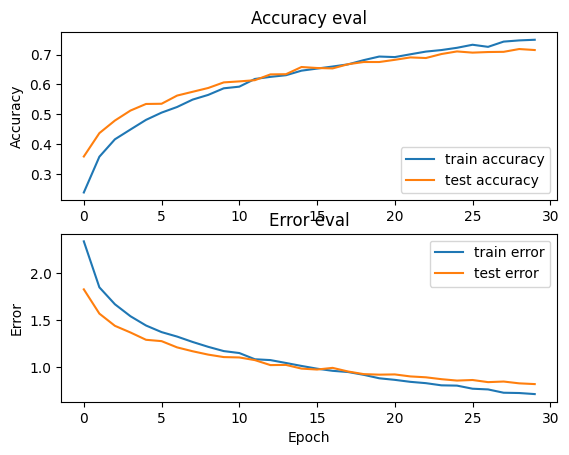

In [34]:
# plot accuracy/error for training and validation
plot_history(history)

In [35]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

79/79 - 0s - loss: 0.8137 - accuracy: 0.7221 - 452ms/epoch - 6ms/step

Test accuracy: 0.7220664620399475


In [36]:
model.save("Music_Genre_10_CNN.h5")

Prediction on Test Set

In [37]:
# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

In [38]:
X_to_predict.shape

(130, 13, 1)

In [39]:
print("Real Genre:", y_to_predict)

Real Genre: 3


In [40]:
# add a dimension to input data for sample - model.predict() expects a 4d array in this case
X_to_predict = X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

In [41]:
X_to_predict.shape

(1, 130, 13, 1)

In [42]:
# perform prediction
prediction = model.predict(X_to_predict)

1/1 [==============================] - 0s 141ms/step


In [43]:
# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", int(predicted_index))

Predicted Genre: 7


In [44]:
# pick a sample to predict from the test set
X_to_predict = X_test[90]
y_to_predict = y_test[90]

print("Real Genre:", y_to_predict)

X_to_predict = X_to_predict[np.newaxis, ...]

prediction = model.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", int(predicted_index))

Real Genre: 1
1/1 [==============================] - 0s 19ms/step
Predicted Genre: 1


In [45]:
len(X_test)

2497

In [46]:
for n in range(10):

  i = random.randint(0,len(X_test))
  # pick a sample to predict from the test set
  X_to_predict = X_test[i]
  y_to_predict = y_test[i]

  print("\nReal Genre:", y_to_predict)

  X_to_predict = X_to_predict[np.newaxis, ...]

  prediction = model.predict(X_to_predict)

  # get index with max value
  predicted_index = np.argmax(prediction, axis=1)

  print("Predicted Genre:", int(predicted_index))


Real Genre: 6
1/1 [==============================] - 0s 19ms/step
Predicted Genre: 6

Real Genre: 2
1/1 [==============================] - 0s 18ms/step
Predicted Genre: 8

Real Genre: 8
1/1 [==============================] - 0s 18ms/step
Predicted Genre: 2

Real Genre: 0
1/1 [==============================] - 0s 20ms/step
Predicted Genre: 0

Real Genre: 0
1/1 [==============================] - 0s 20ms/step
Predicted Genre: 0

Real Genre: 4
1/1 [==============================] - 0s 18ms/step
Predicted Genre: 4

Real Genre: 2
1/1 [==============================] - 0s 18ms/step
Predicted Genre: 9

Real Genre: 2
1/1 [==============================] - 0s 24ms/step
Predicted Genre: 2

Real Genre: 1
1/1 [==============================] - 0s 20ms/step
Predicted Genre: 1

Real Genre: 0
1/1 [==============================] - 0s 18ms/step
Predicted Genre: 0


Generation of Confusion Matrix

79/79 [==============================] - 0s 6ms/step


Text(0.5, 1.0, 'Confusion Matrix (Accuracy=0.72)')

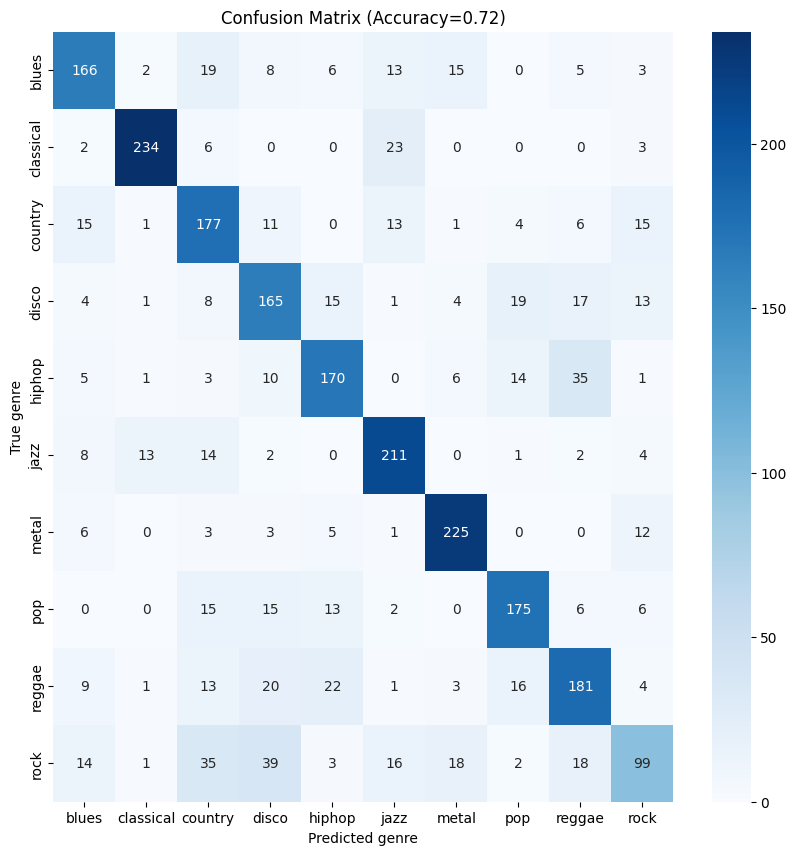

In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the genre labels
genre_labels = ['blues', 'classical', 'country', 'disco', 'hiphop',
                'jazz', 'metal', 'pop', 'reggae', 'rock']

# Get predictions on test set
y_pred = np.argmax(model.predict(X_test), axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)

# Plot confusion matrix with genre labels and accuracy
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted genre')
plt.ylabel('True genre')
plt.xticks(ticks=np.arange(len(genre_labels))+0.5, labels=genre_labels)
plt.yticks(ticks=np.arange(len(genre_labels))+0.5, labels=genre_labels)
plt.title('Confusion Matrix (Accuracy={:.2f})'.format(accuracy))


Prediction on New Songs

In [48]:
# Audio files pre-processing
def process_input(audio_file, track_duration):

  SAMPLE_RATE = 22050
  NUM_MFCC = 13
  N_FTT=2048
  HOP_LENGTH=512
  TRACK_DURATION = track_duration # measured in seconds
  SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
  NUM_SEGMENTS = 10

  samples_per_segment = int(SAMPLES_PER_TRACK / NUM_SEGMENTS)
  num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / HOP_LENGTH)

  signal, sample_rate = librosa.load(audio_file, sr=SAMPLE_RATE)
  
  for d in range(10):

    # calculate start and finish sample for current segment
    start = samples_per_segment * d
    finish = start + samples_per_segment

    # extract mfcc
    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=NUM_MFCC, n_fft=N_FTT, hop_length=HOP_LENGTH)
    mfcc = mfcc.T

    return mfcc

In [49]:
genre_dict = {0:"hiphop",1:"country",2:"jazz",3:"classical",4:"metal",5:"pop",6:"rock",7:"blues",8:"reggae",9:"disco"}

GUI

In [50]:
# Import necessary libraries
import tkinter as tk
from tkinter import filedialog
from keras.models import load_model
import librosa
import numpy as np
import pygame

# Define a function to predict the genre of the selected audio file
def predict_genre():
    # Get the path of the selected audio file
    file_path = filedialog.askopenfilename()
    
    new_input_mfcc = process_input(file_path,30)
    X_to_predict = new_input_mfcc[np.newaxis, ..., np.newaxis]
    
    prediction = model.predict(X_to_predict)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)
    
    # Get the corresponding genre name from the dictionary
    predicted_genre = genre_dict[int(predicted_index)]
    
    # Display the predicted genre on the GUI
    predicted_genre_label.config(text="Predicted Genre: " + predicted_genre)
    
    # Play the selected audio file
    pygame.mixer.music.load(file_path)
    
# Define a function to play the loaded audio file
def play_audio():
    pygame.mixer.music.play()

# Define a function to pause the audio playback
def pause_audio():
    pygame.mixer.music.pause()
    

# Create a GUI window
root = tk.Tk()
root.title("Music Genre Classifier")

# Set the window size and position
root.geometry("400x200")
root.resizable(False, False)
root.configure(background='#373737')

# Create a button to browse and select an audio file
browse_button = tk.Button(root, text="Browse", bg='#28a745', fg='white', font=('Arial', 14), command=predict_genre)
browse_button.pack(pady=10)

# Create a label to display the predicted genre
predicted_genre_label = tk.Label(root, text="", fg='white', font=('Arial', 16), bg='#373737')
predicted_genre_label.pack()

# Create a button to play the audio
play_button = tk.Button(root, text="Play", bg='#007bff', fg='white', font=('Arial', 14), command=play_audio)
play_button.pack(pady=10)

# Create a button to pause the audio
pause_button = tk.Button(root, text="Pause", bg='#dc3545', fg='white', font=('Arial', 14), command=pause_audio)
pause_button.pack(pady=10)

# Initialize the Pygame mixer for playing audio
pygame.mixer.init()

# Run the GUI
root.mainloop()


pygame 2.1.2 (SDL 2.0.18, Python 3.10.1)
Hello from the pygame community. https://www.pygame.org/contribute.html
